In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised
import keras_tuner as kt

2022-11-12 16:59:14.933058: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"

In [4]:
dataset = pd.read_csv('../../data/TFT_energy.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,price,price_dayahead,gen_coal,gen_gas,load_actual,gen_lig,gen_oil,gen_oth_renew,pressure_Barcelona,pressure_Bilbao,...,wind_deg_Bilbao,clouds_all_Bilbao,gen_hyd_river,wind_deg_Seville,wind_speed_Barcelona,wind_speed_Valencia,wind_speed_Bilbao,gen_wind,wind_speed_Madrid,gen_hyd_pump
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,64.92,48.10,4755.0,5196.0,24382.0,328.0,158.0,71.0,1035.0,1035.0,...,229.0,0.0,1009.0,21.0,7.0,1.0,0.0,5890.0,1.0,920.0
2015-01-01 01:00:00+00:00,64.48,47.33,4581.0,4857.0,22734.0,323.0,157.0,73.0,1036.0,1036.0,...,224.0,0.0,973.0,27.0,7.0,0.0,1.0,5461.0,1.0,1164.0
2015-01-01 02:00:00+00:00,59.32,42.27,4131.0,4314.0,21286.0,254.0,160.0,75.0,1036.0,1035.0,...,225.0,0.0,949.0,27.0,7.0,0.0,1.0,5238.0,1.0,1503.0
2015-01-01 03:00:00+00:00,56.04,38.41,3840.0,4130.0,20264.0,187.0,156.0,74.0,1036.0,1035.0,...,221.0,0.0,953.0,27.0,7.0,0.0,1.0,4935.0,1.0,1826.0
2015-01-01 04:00:00+00:00,53.63,35.72,3590.0,4038.0,19905.0,178.0,156.0,74.0,1037.0,1035.0,...,224.0,0.0,952.0,57.0,5.0,2.0,1.0,4618.0,0.0,2109.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,77.02,68.85,2628.0,7634.0,30653.0,0.0,178.0,95.0,1027.0,1033.0,...,57.0,0.0,1135.0,30.0,1.0,2.0,0.0,3113.0,1.0,1.0
2018-12-31 19:00:00+00:00,76.16,68.40,2566.0,7241.0,29735.0,0.0,174.0,95.0,1027.0,1034.0,...,0.0,0.0,1172.0,30.0,3.0,1.0,1.0,3288.0,1.0,1.0
2018-12-31 20:00:00+00:00,74.30,66.88,2422.0,7025.0,28071.0,0.0,168.0,94.0,1028.0,1034.0,...,140.0,0.0,1148.0,50.0,4.0,3.0,1.0,3503.0,1.0,50.0


In [5]:
print(dataset.columns)

Index(['price', 'price_dayahead', 'gen_coal', 'gen_gas', 'load_actual',
       'gen_lig', 'gen_oil', 'gen_oth_renew', 'pressure_Barcelona',
       'pressure_Bilbao', 'gen_waste', 'gen_bio', 'temp_min_Valencia',
       'pressure_Valencia', 'temp_min_Barcelona', 'humidity_Seville',
       'wind_deg_Bilbao', 'clouds_all_Bilbao', 'gen_hyd_river',
       'wind_deg_Seville', 'wind_speed_Barcelona', 'wind_speed_Valencia',
       'wind_speed_Bilbao', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump'],
      dtype='object')


In [81]:
# specify the number of lag hours
n_hours = 24*3
K = 6

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [82]:
# Pre-processing
stages = dataset[['price']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (35063, 1)
stages_supervised.shape: (34986, 78)


In [83]:
stages.max()

price    116.8
dtype: float64

In [84]:
stages_supervised

,var1(t-72),var1(t-71),var1(t-70),var1(t-69),var1(t-68),var1(t-67),var1(t-66),var1(t-65),var1(t-64),var1(t-63),...,var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5)
time,,,,,,,,,,,,,,,,,,,,,
2015-01-04 00:00:00+00:00,64.92,64.48,59.32,56.04,53.63,51.73,51.43,48.98,54.20,58.94,...,72.86,70.10,67.62,55.22,50.54,48.68,48.02,47.06,46.79,47.63
2015-01-04 01:00:00+00:00,64.48,59.32,56.04,53.63,51.73,51.43,48.98,54.20,58.94,59.86,...,70.10,67.62,55.22,50.54,48.68,48.02,47.06,46.79,47.63,47.44
2015-01-04 02:00:00+00:00,59.32,56.04,53.63,51.73,51.43,48.98,54.20,58.94,59.86,60.12,...,67.62,55.22,50.54,48.68,48.02,47.06,46.79,47.63,47.44,50.84
2015-01-04 03:00:00+00:00,56.04,53.63,51.73,51.43,48.98,54.20,58.94,59.86,60.12,62.05,...,55.22,50.54,48.68,48.02,47.06,46.79,47.63,47.44,50.84,54.84
2015-01-04 04:00:00+00:00,53.63,51.73,51.43,48.98,54.20,58.94,59.86,60.12,62.05,62.06,...,50.54,48.68,48.02,47.06,46.79,47.63,47.44,50.84,54.84,59.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 13:00:00+00:00,70.67,68.98,71.57,74.27,78.26,77.10,73.60,69.21,67.53,64.08,...,72.12,71.81,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02
2018-12-31 14:00:00+00:00,68.98,71.57,74.27,78.26,77.10,73.60,69.21,67.53,64.08,65.49,...,71.81,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16
2018-12-31 15:00:00+00:00,71.57,74.27,78.26,77.10,73.60,69.21,67.53,64.08,65.49,60.22,...,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16,74.30


#### Prior unknown covariates (6)

In [85]:
# prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
# print("prior_unknown.shape:", prior_unknown.shape)

# prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, K)
# print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

In [86]:
# prior_unknown_supervised

#### Prior known covariates (9)

In [87]:
prior_known = dataset[['price_dayahead', 'gen_coal', 'gen_gas', 'load_actual',
       'gen_lig', 'gen_oil', 'gen_oth_renew', 'pressure_Barcelona',
       'pressure_Bilbao', 'gen_waste', 'gen_bio', 'temp_min_Valencia',
       'pressure_Valencia', 'temp_min_Barcelona', 'humidity_Seville',
       'wind_deg_Bilbao', 'clouds_all_Bilbao', 'gen_hyd_river',
       'wind_deg_Seville', 'wind_speed_Barcelona', 'wind_speed_Valencia',
       'wind_speed_Bilbao', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, K)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (35063, 25)
prior_known_supervised.shape: (34986, 1950)


In [88]:
# prior_known_supervised

### N_out, N_in, K

In [89]:
past_cov = dataset[['price_dayahead', 'gen_coal', 'gen_gas', 'load_actual',
       'gen_lig', 'gen_oil', 'gen_oth_renew', 'pressure_Barcelona',
       'pressure_Bilbao', 'gen_waste', 'gen_bio', 'temp_min_Valencia',
       'pressure_Valencia', 'temp_min_Barcelona', 'humidity_Seville',
       'wind_deg_Bilbao', 'clouds_all_Bilbao', 'gen_hyd_river',
       'wind_deg_Seville', 'wind_speed_Barcelona', 'wind_speed_Valencia',
       'wind_speed_Bilbao', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump']]

past_cov_supervised = series_to_supervised(past_cov, n_hours, K)
print("past_cov_supervised.shape:", past_cov_supervised.shape)

past_cov_supervised.shape: (34986, 1950)


In [90]:
# past_cov_supervised  # 6 + 9 = 15 features

In [91]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [92]:
# past_ws_supervised  # 4

In [93]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*past_cov.shape[1]:(i+1)*past_cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [94]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised, past_ws_supervised], axis=1)
past_cov_ws_supervised = past_cov_ws_supervised[columns]


In [95]:
# past_cov_ws_supervised

In [96]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, K*prior_known.shape[1]:]  # shift 2 days for prior known covariates
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-66),shift_prior_known_supervised_var2(t-66),shift_prior_known_supervised_var3(t-66),shift_prior_known_supervised_var4(t-66),shift_prior_known_supervised_var5(t-66),shift_prior_known_supervised_var6(t-66),shift_prior_known_supervised_var7(t-66),shift_prior_known_supervised_var8(t-66),shift_prior_known_supervised_var9(t-66),shift_prior_known_supervised_var10(t-66),...,shift_prior_known_supervised_var16(t+5),shift_prior_known_supervised_var17(t+5),shift_prior_known_supervised_var18(t+5),shift_prior_known_supervised_var19(t+5),shift_prior_known_supervised_var20(t+5),shift_prior_known_supervised_var21(t+5),shift_prior_known_supervised_var22(t+5),shift_prior_known_supervised_var23(t+5),shift_prior_known_supervised_var24(t+5),shift_prior_known_supervised_var25(t+5)
0,36.22,3208.0,4030.0,20377.0,172.0,160.0,72.0,1037.0,1036.0,189.0,...,233.0,37.0,1352.0,58.0,1.0,2.0,1.0,7950.0,1.0,1341.0
1,32.40,3335.0,4052.0,20094.0,177.0,161.0,73.0,1038.0,1036.0,198.0,...,226.0,37.0,1433.0,58.0,1.0,2.0,1.0,8228.0,1.0,378.0
2,36.60,3437.0,4137.0,20637.0,177.0,163.0,74.0,1038.0,1036.0,198.0,...,216.0,37.0,1561.0,60.0,2.0,1.0,1.0,8341.0,1.0,0.0
3,43.10,3516.0,4059.0,22250.0,173.0,167.0,72.0,1038.0,1036.0,204.0,...,209.0,37.0,1573.0,60.0,1.0,1.0,1.0,8569.0,1.0,0.0
4,45.14,3845.0,3931.0,23547.0,226.0,166.0,73.0,1038.0,1036.0,206.0,...,213.0,37.0,1451.0,60.0,1.0,1.0,1.0,8433.0,1.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34981,66.00,2931.0,9149.0,32642.0,718.0,294.0,103.0,1028.0,1033.0,314.0,...,57.0,0.0,1135.0,30.0,1.0,2.0,0.0,3113.0,1.0,1.0
34982,62.09,2889.0,8024.0,32155.0,675.0,294.0,103.0,1028.0,1033.0,315.0,...,0.0,0.0,1172.0,30.0,3.0,1.0,1.0,3288.0,1.0,1.0
34983,61.77,2871.0,6871.0,30428.0,569.0,291.0,104.0,1029.0,1033.0,314.0,...,140.0,0.0,1148.0,50.0,4.0,3.0,1.0,3503.0,1.0,50.0
34984,58.43,2619.0,5822.0,28015.0,310.0,288.0,103.0,1029.0,1033.0,313.0,...,120.0,0.0,1128.0,60.0,5.0,2.0,1.0,3586.0,2.0,108.0


In [97]:
shift_prior_known_past_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], 
                                                     axis=1)


In [98]:
# shift_prior_known_past_cov_ws_supervised

In [99]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5)
0,50.54,48.68,48.02,47.06,46.79,47.63
1,48.68,48.02,47.06,46.79,47.63,47.44
2,48.02,47.06,46.79,47.63,47.44,50.84
3,47.06,46.79,47.63,47.44,50.84,54.84
4,46.79,47.63,47.44,50.84,54.84,59.95
...,...,...,...,...,...,...
34981,71.95,70.85,71.36,75.13,77.61,77.02
34982,70.85,71.36,75.13,77.61,77.02,76.16
34983,71.36,75.13,77.61,77.02,76.16,74.30
34984,75.13,77.61,77.02,76.16,74.30,69.89


### Concatenation

In [100]:
all_data = concat([shift_prior_known_past_cov_ws_supervised, future_ws_supervised], axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (34986, 3678)


### Train & Test set

In [101]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 27988


In [102]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

3672

### Normalization

In [103]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (27988, 3672) (27988, 6) (6998, 3672) (6998, 6)


In [104]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (27988, 72, 51) (27988, 6) (6998, 72, 51) (6998, 6)


### Model

In [109]:
# define model
model_cnn = keras.Sequential()
model_cnn.add(layers.Conv1D(filters=256, 
                            kernel_size=2, 
                            activation='relu', 
                            kernel_regularizer=keras.regularizers.L1L2(l1=1e-4, l2=1e-5),
                            input_shape=(train_X.shape[1], train_X.shape[2])))

model_cnn.add(layers.Flatten())

# l1 and l2 becomes bigger --> smooth decrease --> more epoches
model_cnn.add(layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-4, l2=1e-5)))
model_cnn.add(layers.Dense(train_y.shape[1]))
model_cnn.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 71, 256)           26368     
_________________________________________________________________
flatten_21 (Flatten)         (None, 18176)             0         
_________________________________________________________________
dense_44 (Dense)             (None, 128)               2326656   
_________________________________________________________________
dense_45 (Dense)             (None, 6)                 774       
Total params: 2,353,798
Trainable params: 2,353,798
Non-trainable params: 0
_________________________________________________________________


Epoch 1/8000
55/55 - 2s - loss: 1.9140 - mae: 0.1091 - val_loss: 1.5749 - val_mae: 0.1767

Epoch 00001: val_mae improved from inf to 0.17666, saving model to cnn_shift_best_model_6h_cp1.h5
Epoch 2/8000
55/55 - 0s - loss: 1.2586 - mae: 0.0691 - val_loss: 1.0132 - val_mae: 0.1372

Epoch 00002: val_mae improved from 0.17666 to 0.13717, saving model to cnn_shift_best_model_6h_cp1.h5
Epoch 3/8000
55/55 - 1s - loss: 0.8163 - mae: 0.0600 - val_loss: 0.6829 - val_mae: 0.1189

Epoch 00003: val_mae improved from 0.13717 to 0.11889, saving model to cnn_shift_best_model_6h_cp1.h5
Epoch 4/8000
55/55 - 1s - loss: 0.5979 - mae: 0.0579 - val_loss: 0.5488 - val_mae: 0.1051

Epoch 00004: val_mae improved from 0.11889 to 0.10514, saving model to cnn_shift_best_model_6h_cp1.h5
Epoch 5/8000
55/55 - 1s - loss: 0.4966 - mae: 0.0565 - val_loss: 0.4658 - val_mae: 0.1037

Epoch 00005: val_mae improved from 0.10514 to 0.10369, saving model to cnn_shift_best_model_6h_cp1.h5
Epoch 6/8000
55/55 - 1s - loss: 0.4254 


Epoch 00054: val_mae improved from 0.06812 to 0.06454, saving model to cnn_shift_best_model_6h_cp1.h5
Epoch 55/8000
55/55 - 1s - loss: 0.0165 - mae: 0.0457 - val_loss: 0.0197 - val_mae: 0.0696

Epoch 00055: val_mae did not improve from 0.06454
Epoch 56/8000
55/55 - 0s - loss: 0.0159 - mae: 0.0452 - val_loss: 0.0181 - val_mae: 0.0619

Epoch 00056: val_mae improved from 0.06454 to 0.06192, saving model to cnn_shift_best_model_6h_cp1.h5
Epoch 57/8000
55/55 - 1s - loss: 0.0154 - mae: 0.0446 - val_loss: 0.0202 - val_mae: 0.0775

Epoch 00057: val_mae did not improve from 0.06192
Epoch 58/8000
55/55 - 0s - loss: 0.0151 - mae: 0.0451 - val_loss: 0.0183 - val_mae: 0.0688

Epoch 00058: val_mae did not improve from 0.06192
Epoch 59/8000
55/55 - 0s - loss: 0.0146 - mae: 0.0441 - val_loss: 0.0178 - val_mae: 0.0682

Epoch 00059: val_mae did not improve from 0.06192
Epoch 60/8000
55/55 - 0s - loss: 0.0142 - mae: 0.0441 - val_loss: 0.0160 - val_mae: 0.0586

Epoch 00060: val_mae improved from 0.06192 


Epoch 00107: val_mae did not improve from 0.04483
Epoch 108/8000
55/55 - 0s - loss: 0.0081 - mae: 0.0373 - val_loss: 0.0090 - val_mae: 0.0443

Epoch 00108: val_mae improved from 0.04483 to 0.04425, saving model to cnn_shift_best_model_6h_cp1.h5
Epoch 109/8000
55/55 - 0s - loss: 0.0081 - mae: 0.0373 - val_loss: 0.0092 - val_mae: 0.0464

Epoch 00109: val_mae did not improve from 0.04425
Epoch 110/8000
55/55 - 1s - loss: 0.0080 - mae: 0.0371 - val_loss: 0.0092 - val_mae: 0.0467

Epoch 00110: val_mae did not improve from 0.04425
Epoch 111/8000
55/55 - 0s - loss: 0.0080 - mae: 0.0367 - val_loss: 0.0093 - val_mae: 0.0477

Epoch 00111: val_mae did not improve from 0.04425
Epoch 112/8000
55/55 - 0s - loss: 0.0080 - mae: 0.0375 - val_loss: 0.0092 - val_mae: 0.0472

Epoch 00112: val_mae did not improve from 0.04425
Epoch 113/8000
55/55 - 0s - loss: 0.0079 - mae: 0.0367 - val_loss: 0.0090 - val_mae: 0.0454

Epoch 00113: val_mae did not improve from 0.04425
Epoch 114/8000
55/55 - 1s - loss: 0.007

55/55 - 0s - loss: 0.0072 - mae: 0.0355 - val_loss: 0.0080 - val_mae: 0.0424

Epoch 00162: val_mae did not improve from 0.04034
Epoch 163/8000
55/55 - 0s - loss: 0.0071 - mae: 0.0353 - val_loss: 0.0079 - val_mae: 0.0415

Epoch 00163: val_mae did not improve from 0.04034
Epoch 164/8000
55/55 - 1s - loss: 0.0072 - mae: 0.0358 - val_loss: 0.0078 - val_mae: 0.0400

Epoch 00164: val_mae improved from 0.04034 to 0.04001, saving model to cnn_shift_best_model_6h_cp1.h5
Epoch 165/8000
55/55 - 1s - loss: 0.0072 - mae: 0.0355 - val_loss: 0.0079 - val_mae: 0.0413

Epoch 00165: val_mae did not improve from 0.04001
Epoch 166/8000
55/55 - 0s - loss: 0.0071 - mae: 0.0353 - val_loss: 0.0078 - val_mae: 0.0407

Epoch 00166: val_mae did not improve from 0.04001
Epoch 167/8000
55/55 - 1s - loss: 0.0071 - mae: 0.0354 - val_loss: 0.0078 - val_mae: 0.0405

Epoch 00167: val_mae did not improve from 0.04001
Epoch 168/8000
55/55 - 1s - loss: 0.0071 - mae: 0.0354 - val_loss: 0.0079 - val_mae: 0.0422

Epoch 00168:


Epoch 00217: val_mae did not improve from 0.03882
Epoch 218/8000
55/55 - 0s - loss: 0.0066 - mae: 0.0341 - val_loss: 0.0073 - val_mae: 0.0400

Epoch 00218: val_mae did not improve from 0.03882
Epoch 219/8000
55/55 - 1s - loss: 0.0066 - mae: 0.0343 - val_loss: 0.0073 - val_mae: 0.0392

Epoch 00219: val_mae did not improve from 0.03882
Epoch 220/8000
55/55 - 0s - loss: 0.0067 - mae: 0.0348 - val_loss: 0.0073 - val_mae: 0.0394

Epoch 00220: val_mae did not improve from 0.03882
Epoch 221/8000
55/55 - 1s - loss: 0.0067 - mae: 0.0348 - val_loss: 0.0072 - val_mae: 0.0390

Epoch 00221: val_mae did not improve from 0.03882
Epoch 222/8000
55/55 - 1s - loss: 0.0066 - mae: 0.0342 - val_loss: 0.0073 - val_mae: 0.0403

Epoch 00222: val_mae did not improve from 0.03882
Epoch 223/8000
55/55 - 1s - loss: 0.0066 - mae: 0.0340 - val_loss: 0.0073 - val_mae: 0.0396

Epoch 00223: val_mae did not improve from 0.03882
Epoch 224/8000
55/55 - 1s - loss: 0.0066 - mae: 0.0340 - val_loss: 0.0074 - val_mae: 0.0413

Epoch 274/8000
55/55 - 0s - loss: 0.0063 - mae: 0.0334 - val_loss: 0.0069 - val_mae: 0.0391

Epoch 00274: val_mae did not improve from 0.03782
Epoch 275/8000
55/55 - 1s - loss: 0.0062 - mae: 0.0333 - val_loss: 0.0070 - val_mae: 0.0397

Epoch 00275: val_mae did not improve from 0.03782
Epoch 276/8000
55/55 - 0s - loss: 0.0063 - mae: 0.0341 - val_loss: 0.0071 - val_mae: 0.0407

Epoch 00276: val_mae did not improve from 0.03782
Epoch 277/8000
55/55 - 0s - loss: 0.0063 - mae: 0.0340 - val_loss: 0.0068 - val_mae: 0.0382

Epoch 00277: val_mae did not improve from 0.03782
Epoch 278/8000
55/55 - 0s - loss: 0.0062 - mae: 0.0335 - val_loss: 0.0072 - val_mae: 0.0419

Epoch 00278: val_mae did not improve from 0.03782
Epoch 279/8000
55/55 - 1s - loss: 0.0062 - mae: 0.0332 - val_loss: 0.0069 - val_mae: 0.0394

Epoch 00279: val_mae did not improve from 0.03782
Epoch 280/8000
55/55 - 0s - loss: 0.0062 - mae: 0.0333 - val_loss: 0.0069 - val_mae: 0.0393

Epoch 00280: val_mae did not improve from 0.03782


Epoch 00330: val_mae did not improve from 0.03735
Epoch 331/8000
55/55 - 1s - loss: 0.0059 - mae: 0.0329 - val_loss: 0.0065 - val_mae: 0.0379

Epoch 00331: val_mae did not improve from 0.03735
Epoch 332/8000
55/55 - 1s - loss: 0.0060 - mae: 0.0330 - val_loss: 0.0068 - val_mae: 0.0406

Epoch 00332: val_mae did not improve from 0.03735
Epoch 333/8000
55/55 - 0s - loss: 0.0059 - mae: 0.0328 - val_loss: 0.0066 - val_mae: 0.0390

Epoch 00333: val_mae did not improve from 0.03735
Epoch 334/8000
55/55 - 0s - loss: 0.0059 - mae: 0.0327 - val_loss: 0.0066 - val_mae: 0.0383

Epoch 00334: val_mae did not improve from 0.03735
Epoch 335/8000
55/55 - 1s - loss: 0.0059 - mae: 0.0328 - val_loss: 0.0066 - val_mae: 0.0384

Epoch 00335: val_mae did not improve from 0.03735
Epoch 336/8000
55/55 - 0s - loss: 0.0059 - mae: 0.0326 - val_loss: 0.0066 - val_mae: 0.0384

Epoch 00336: val_mae did not improve from 0.03735
Epoch 337/8000
55/55 - 0s - loss: 0.0059 - mae: 0.0328 - val_loss: 0.0066 - val_mae: 0.0387


Epoch 00386: val_mae did not improve from 0.03648
Epoch 387/8000
55/55 - 0s - loss: 0.0057 - mae: 0.0323 - val_loss: 0.0063 - val_mae: 0.0381

Epoch 00387: val_mae did not improve from 0.03648
Epoch 388/8000
55/55 - 1s - loss: 0.0057 - mae: 0.0322 - val_loss: 0.0065 - val_mae: 0.0399

Epoch 00388: val_mae did not improve from 0.03648
Epoch 389/8000
55/55 - 1s - loss: 0.0057 - mae: 0.0322 - val_loss: 0.0063 - val_mae: 0.0379

Epoch 00389: val_mae did not improve from 0.03648
Epoch 390/8000
55/55 - 0s - loss: 0.0057 - mae: 0.0322 - val_loss: 0.0062 - val_mae: 0.0367

Epoch 00390: val_mae did not improve from 0.03648
Epoch 391/8000
55/55 - 1s - loss: 0.0057 - mae: 0.0325 - val_loss: 0.0064 - val_mae: 0.0392

Epoch 00391: val_mae did not improve from 0.03648
Epoch 392/8000
55/55 - 1s - loss: 0.0057 - mae: 0.0323 - val_loss: 0.0065 - val_mae: 0.0401

Epoch 00392: val_mae did not improve from 0.03648
Epoch 393/8000
55/55 - 0s - loss: 0.0057 - mae: 0.0324 - val_loss: 0.0066 - val_mae: 0.0405

55/55 - 0s - loss: 0.0055 - mae: 0.0317 - val_loss: 0.0061 - val_mae: 0.0367

Epoch 00443: val_mae did not improve from 0.03582
Epoch 444/8000
55/55 - 0s - loss: 0.0055 - mae: 0.0317 - val_loss: 0.0062 - val_mae: 0.0382

Epoch 00444: val_mae did not improve from 0.03582
Epoch 445/8000
55/55 - 0s - loss: 0.0055 - mae: 0.0318 - val_loss: 0.0061 - val_mae: 0.0363

Epoch 00445: val_mae did not improve from 0.03582
Epoch 446/8000
55/55 - 1s - loss: 0.0055 - mae: 0.0317 - val_loss: 0.0061 - val_mae: 0.0364

Epoch 00446: val_mae did not improve from 0.03582
Epoch 447/8000
55/55 - 0s - loss: 0.0055 - mae: 0.0316 - val_loss: 0.0061 - val_mae: 0.0364

Epoch 00447: val_mae did not improve from 0.03582
Epoch 448/8000
55/55 - 0s - loss: 0.0055 - mae: 0.0317 - val_loss: 0.0064 - val_mae: 0.0396

Epoch 00448: val_mae did not improve from 0.03582
Epoch 449/8000
55/55 - 1s - loss: 0.0056 - mae: 0.0319 - val_loss: 0.0060 - val_mae: 0.0360

Epoch 00449: val_mae did not improve from 0.03582
Epoch 450/8000


Epoch 00499: val_mae did not improve from 0.03530
Epoch 500/8000
55/55 - 0s - loss: 0.0055 - mae: 0.0317 - val_loss: 0.0060 - val_mae: 0.0364

Epoch 00500: val_mae did not improve from 0.03530
Epoch 501/8000
55/55 - 0s - loss: 0.0055 - mae: 0.0316 - val_loss: 0.0063 - val_mae: 0.0390

Epoch 00501: val_mae did not improve from 0.03530
Epoch 502/8000
55/55 - 1s - loss: 0.0055 - mae: 0.0318 - val_loss: 0.0062 - val_mae: 0.0380

Epoch 00502: val_mae did not improve from 0.03530
Epoch 503/8000
55/55 - 0s - loss: 0.0055 - mae: 0.0316 - val_loss: 0.0060 - val_mae: 0.0362

Epoch 00503: val_mae did not improve from 0.03530
Epoch 504/8000
55/55 - 0s - loss: 0.0055 - mae: 0.0319 - val_loss: 0.0060 - val_mae: 0.0367

Epoch 00504: val_mae did not improve from 0.03530
Epoch 505/8000
55/55 - 1s - loss: 0.0055 - mae: 0.0315 - val_loss: 0.0061 - val_mae: 0.0370

Epoch 00505: val_mae did not improve from 0.03530
Epoch 506/8000
55/55 - 1s - loss: 0.0054 - mae: 0.0313 - val_loss: 0.0060 - val_mae: 0.0359

55/55 - 0s - loss: 0.0054 - mae: 0.0311 - val_loss: 0.0059 - val_mae: 0.0359

Epoch 00556: val_mae did not improve from 0.03500
Epoch 557/8000
55/55 - 1s - loss: 0.0054 - mae: 0.0310 - val_loss: 0.0060 - val_mae: 0.0365

Epoch 00557: val_mae did not improve from 0.03500
Epoch 558/8000
55/55 - 1s - loss: 0.0054 - mae: 0.0312 - val_loss: 0.0064 - val_mae: 0.0410

Epoch 00558: val_mae did not improve from 0.03500
Epoch 559/8000
55/55 - 0s - loss: 0.0054 - mae: 0.0313 - val_loss: 0.0063 - val_mae: 0.0393

Epoch 00559: val_mae did not improve from 0.03500
Epoch 560/8000
55/55 - 0s - loss: 0.0054 - mae: 0.0314 - val_loss: 0.0060 - val_mae: 0.0366

Epoch 00560: val_mae did not improve from 0.03500
Epoch 561/8000
55/55 - 0s - loss: 0.0054 - mae: 0.0311 - val_loss: 0.0058 - val_mae: 0.0351

Epoch 00561: val_mae did not improve from 0.03500
Epoch 562/8000
55/55 - 0s - loss: 0.0054 - mae: 0.0314 - val_loss: 0.0061 - val_mae: 0.0374

Epoch 00562: val_mae did not improve from 0.03500
Epoch 563/8000

55/55 - 1s - loss: 0.0053 - mae: 0.0313 - val_loss: 0.0061 - val_mae: 0.0385

Epoch 00613: val_mae did not improve from 0.03488
Epoch 614/8000
55/55 - 1s - loss: 0.0053 - mae: 0.0310 - val_loss: 0.0059 - val_mae: 0.0362

Epoch 00614: val_mae did not improve from 0.03488
Epoch 615/8000
55/55 - 0s - loss: 0.0053 - mae: 0.0309 - val_loss: 0.0063 - val_mae: 0.0400

Epoch 00615: val_mae did not improve from 0.03488
Epoch 616/8000
55/55 - 0s - loss: 0.0053 - mae: 0.0309 - val_loss: 0.0059 - val_mae: 0.0366

Epoch 00616: val_mae did not improve from 0.03488
Epoch 617/8000
55/55 - 1s - loss: 0.0053 - mae: 0.0309 - val_loss: 0.0060 - val_mae: 0.0369

Epoch 00617: val_mae did not improve from 0.03488
Epoch 618/8000
55/55 - 1s - loss: 0.0053 - mae: 0.0313 - val_loss: 0.0059 - val_mae: 0.0359

Epoch 00618: val_mae did not improve from 0.03488
Epoch 619/8000
55/55 - 1s - loss: 0.0053 - mae: 0.0311 - val_loss: 0.0058 - val_mae: 0.0356

Epoch 00619: val_mae did not improve from 0.03488
Epoch 620/8000

55/55 - 1s - loss: 0.0053 - mae: 0.0313 - val_loss: 0.0057 - val_mae: 0.0346

Epoch 00670: val_mae improved from 0.03465 to 0.03462, saving model to cnn_shift_best_model_6h_cp1.h5
Epoch 671/8000
55/55 - 1s - loss: 0.0053 - mae: 0.0308 - val_loss: 0.0061 - val_mae: 0.0383

Epoch 00671: val_mae did not improve from 0.03462
Epoch 672/8000
55/55 - 1s - loss: 0.0053 - mae: 0.0311 - val_loss: 0.0060 - val_mae: 0.0380

Epoch 00672: val_mae did not improve from 0.03462
Epoch 673/8000
55/55 - 1s - loss: 0.0053 - mae: 0.0308 - val_loss: 0.0059 - val_mae: 0.0368

Epoch 00673: val_mae did not improve from 0.03462
Epoch 674/8000
55/55 - 0s - loss: 0.0052 - mae: 0.0307 - val_loss: 0.0058 - val_mae: 0.0357

Epoch 00674: val_mae did not improve from 0.03462
Epoch 675/8000
55/55 - 1s - loss: 0.0052 - mae: 0.0307 - val_loss: 0.0059 - val_mae: 0.0366

Epoch 00675: val_mae did not improve from 0.03462
Epoch 676/8000
55/55 - 0s - loss: 0.0052 - mae: 0.0307 - val_loss: 0.0059 - val_mae: 0.0369

Epoch 00676:


Epoch 00726: val_mae did not improve from 0.03459
Epoch 727/8000
55/55 - 1s - loss: 0.0052 - mae: 0.0306 - val_loss: 0.0057 - val_mae: 0.0349

Epoch 00727: val_mae did not improve from 0.03459
Epoch 728/8000
55/55 - 0s - loss: 0.0052 - mae: 0.0306 - val_loss: 0.0057 - val_mae: 0.0351

Epoch 00728: val_mae did not improve from 0.03459
Epoch 729/8000
55/55 - 1s - loss: 0.0052 - mae: 0.0305 - val_loss: 0.0059 - val_mae: 0.0371

Epoch 00729: val_mae did not improve from 0.03459
Epoch 730/8000
55/55 - 0s - loss: 0.0052 - mae: 0.0306 - val_loss: 0.0057 - val_mae: 0.0351

Epoch 00730: val_mae did not improve from 0.03459
Epoch 731/8000
55/55 - 1s - loss: 0.0052 - mae: 0.0308 - val_loss: 0.0057 - val_mae: 0.0348

Epoch 00731: val_mae did not improve from 0.03459
Epoch 732/8000
55/55 - 1s - loss: 0.0052 - mae: 0.0307 - val_loss: 0.0057 - val_mae: 0.0349

Epoch 00732: val_mae did not improve from 0.03459
Epoch 733/8000
55/55 - 1s - loss: 0.0052 - mae: 0.0306 - val_loss: 0.0057 - val_mae: 0.0353


Epoch 00782: val_mae did not improve from 0.03430
Epoch 783/8000
55/55 - 0s - loss: 0.0052 - mae: 0.0306 - val_loss: 0.0056 - val_mae: 0.0346

Epoch 00783: val_mae did not improve from 0.03430
Epoch 784/8000
55/55 - 1s - loss: 0.0051 - mae: 0.0304 - val_loss: 0.0057 - val_mae: 0.0350

Epoch 00784: val_mae did not improve from 0.03430
Epoch 785/8000
55/55 - 0s - loss: 0.0052 - mae: 0.0308 - val_loss: 0.0057 - val_mae: 0.0354

Epoch 00785: val_mae did not improve from 0.03430
Epoch 786/8000
55/55 - 0s - loss: 0.0051 - mae: 0.0304 - val_loss: 0.0057 - val_mae: 0.0353

Epoch 00786: val_mae did not improve from 0.03430
Epoch 787/8000
55/55 - 0s - loss: 0.0052 - mae: 0.0307 - val_loss: 0.0057 - val_mae: 0.0352

Epoch 00787: val_mae did not improve from 0.03430
Epoch 788/8000
55/55 - 0s - loss: 0.0052 - mae: 0.0305 - val_loss: 0.0056 - val_mae: 0.0343

Epoch 00788: val_mae did not improve from 0.03430
Epoch 789/8000
55/55 - 1s - loss: 0.0052 - mae: 0.0306 - val_loss: 0.0060 - val_mae: 0.0386


Epoch 00838: val_mae did not improve from 0.03398
Epoch 839/8000
55/55 - 0s - loss: 0.0051 - mae: 0.0305 - val_loss: 0.0058 - val_mae: 0.0369

Epoch 00839: val_mae did not improve from 0.03398
Epoch 840/8000
55/55 - 0s - loss: 0.0051 - mae: 0.0304 - val_loss: 0.0056 - val_mae: 0.0348

Epoch 00840: val_mae did not improve from 0.03398
Epoch 841/8000
55/55 - 0s - loss: 0.0051 - mae: 0.0303 - val_loss: 0.0055 - val_mae: 0.0340

Epoch 00841: val_mae did not improve from 0.03398
Epoch 842/8000
55/55 - 1s - loss: 0.0051 - mae: 0.0306 - val_loss: 0.0057 - val_mae: 0.0352

Epoch 00842: val_mae did not improve from 0.03398
Epoch 843/8000
55/55 - 1s - loss: 0.0051 - mae: 0.0302 - val_loss: 0.0056 - val_mae: 0.0347

Epoch 00843: val_mae did not improve from 0.03398
Epoch 844/8000
55/55 - 0s - loss: 0.0051 - mae: 0.0302 - val_loss: 0.0058 - val_mae: 0.0362

Epoch 00844: val_mae did not improve from 0.03398
Epoch 845/8000
55/55 - 0s - loss: 0.0051 - mae: 0.0305 - val_loss: 0.0058 - val_mae: 0.0365

55/55 - 0s - loss: 0.0051 - mae: 0.0303 - val_loss: 0.0056 - val_mae: 0.0352

Epoch 00896: val_mae did not improve from 0.03398
Epoch 897/8000
55/55 - 0s - loss: 0.0051 - mae: 0.0303 - val_loss: 0.0056 - val_mae: 0.0343

Epoch 00897: val_mae did not improve from 0.03398
Epoch 898/8000
55/55 - 0s - loss: 0.0051 - mae: 0.0303 - val_loss: 0.0058 - val_mae: 0.0369

Epoch 00898: val_mae did not improve from 0.03398
Epoch 899/8000
55/55 - 0s - loss: 0.0051 - mae: 0.0307 - val_loss: 0.0058 - val_mae: 0.0369

Epoch 00899: val_mae did not improve from 0.03398
Epoch 900/8000
55/55 - 1s - loss: 0.0051 - mae: 0.0303 - val_loss: 0.0056 - val_mae: 0.0344

Epoch 00900: val_mae did not improve from 0.03398
Epoch 901/8000
55/55 - 1s - loss: 0.0051 - mae: 0.0301 - val_loss: 0.0055 - val_mae: 0.0340

Epoch 00901: val_mae did not improve from 0.03398
Epoch 902/8000
55/55 - 1s - loss: 0.0051 - mae: 0.0303 - val_loss: 0.0056 - val_mae: 0.0345

Epoch 00902: val_mae did not improve from 0.03398
Epoch 903/8000

55/55 - 1s - loss: 0.0051 - mae: 0.0304 - val_loss: 0.0055 - val_mae: 0.0340

Epoch 00953: val_mae did not improve from 0.03393
Epoch 954/8000
55/55 - 1s - loss: 0.0051 - mae: 0.0304 - val_loss: 0.0056 - val_mae: 0.0349

Epoch 00954: val_mae did not improve from 0.03393
Epoch 955/8000
55/55 - 0s - loss: 0.0050 - mae: 0.0301 - val_loss: 0.0056 - val_mae: 0.0348

Epoch 00955: val_mae did not improve from 0.03393
Epoch 956/8000
55/55 - 0s - loss: 0.0050 - mae: 0.0301 - val_loss: 0.0058 - val_mae: 0.0372

Epoch 00956: val_mae did not improve from 0.03393
Epoch 957/8000
55/55 - 1s - loss: 0.0051 - mae: 0.0303 - val_loss: 0.0057 - val_mae: 0.0359

Epoch 00957: val_mae did not improve from 0.03393
Epoch 958/8000
55/55 - 0s - loss: 0.0050 - mae: 0.0301 - val_loss: 0.0055 - val_mae: 0.0340

Epoch 00958: val_mae did not improve from 0.03393
Epoch 959/8000
55/55 - 1s - loss: 0.0050 - mae: 0.0301 - val_loss: 0.0055 - val_mae: 0.0339

Epoch 00959: val_mae did not improve from 0.03393
Epoch 960/8000


Epoch 01009: val_mae did not improve from 0.03368
Epoch 1010/8000
55/55 - 1s - loss: 0.0050 - mae: 0.0301 - val_loss: 0.0055 - val_mae: 0.0344

Epoch 01010: val_mae did not improve from 0.03368
Epoch 1011/8000
55/55 - 0s - loss: 0.0050 - mae: 0.0301 - val_loss: 0.0056 - val_mae: 0.0349

Epoch 01011: val_mae did not improve from 0.03368
Epoch 1012/8000
55/55 - 0s - loss: 0.0050 - mae: 0.0302 - val_loss: 0.0054 - val_mae: 0.0337

Epoch 01012: val_mae improved from 0.03368 to 0.03367, saving model to cnn_shift_best_model_6h_cp1.h5
Epoch 1013/8000
55/55 - 0s - loss: 0.0050 - mae: 0.0300 - val_loss: 0.0055 - val_mae: 0.0340

Epoch 01013: val_mae did not improve from 0.03367
Epoch 1014/8000
55/55 - 1s - loss: 0.0050 - mae: 0.0302 - val_loss: 0.0055 - val_mae: 0.0340

Epoch 01014: val_mae did not improve from 0.03367
Epoch 1015/8000
55/55 - 0s - loss: 0.0050 - mae: 0.0303 - val_loss: 0.0055 - val_mae: 0.0341

Epoch 01015: val_mae did not improve from 0.03367
Epoch 1016/8000
55/55 - 0s - loss


Epoch 01066: val_mae did not improve from 0.03367
Epoch 1067/8000
55/55 - 0s - loss: 0.0050 - mae: 0.0299 - val_loss: 0.0055 - val_mae: 0.0344

Epoch 01067: val_mae did not improve from 0.03367
Epoch 1068/8000
55/55 - 1s - loss: 0.0050 - mae: 0.0302 - val_loss: 0.0055 - val_mae: 0.0341

Epoch 01068: val_mae did not improve from 0.03367
Epoch 1069/8000
55/55 - 1s - loss: 0.0050 - mae: 0.0305 - val_loss: 0.0055 - val_mae: 0.0349

Epoch 01069: val_mae did not improve from 0.03367
Epoch 1070/8000
55/55 - 1s - loss: 0.0050 - mae: 0.0300 - val_loss: 0.0055 - val_mae: 0.0341

Epoch 01070: val_mae did not improve from 0.03367
Epoch 1071/8000
55/55 - 0s - loss: 0.0050 - mae: 0.0300 - val_loss: 0.0056 - val_mae: 0.0352

Epoch 01071: val_mae did not improve from 0.03367
Epoch 1072/8000
55/55 - 1s - loss: 0.0050 - mae: 0.0302 - val_loss: 0.0055 - val_mae: 0.0345

Epoch 01072: val_mae did not improve from 0.03367
Epoch 1073/8000
55/55 - 0s - loss: 0.0050 - mae: 0.0299 - val_loss: 0.0055 - val_mae:

55/55 - 0s - loss: 0.0050 - mae: 0.0305 - val_loss: 0.0054 - val_mae: 0.0338

Epoch 01123: val_mae did not improve from 0.03349
Epoch 1124/8000
55/55 - 0s - loss: 0.0050 - mae: 0.0299 - val_loss: 0.0056 - val_mae: 0.0359

Epoch 01124: val_mae did not improve from 0.03349
Epoch 1125/8000
55/55 - 0s - loss: 0.0050 - mae: 0.0300 - val_loss: 0.0055 - val_mae: 0.0345

Epoch 01125: val_mae did not improve from 0.03349
Epoch 1126/8000
55/55 - 0s - loss: 0.0050 - mae: 0.0301 - val_loss: 0.0056 - val_mae: 0.0358

Epoch 01126: val_mae did not improve from 0.03349
Epoch 1127/8000
55/55 - 0s - loss: 0.0049 - mae: 0.0299 - val_loss: 0.0056 - val_mae: 0.0353

Epoch 01127: val_mae did not improve from 0.03349
Epoch 1128/8000
55/55 - 1s - loss: 0.0049 - mae: 0.0298 - val_loss: 0.0055 - val_mae: 0.0348

Epoch 01128: val_mae did not improve from 0.03349
Epoch 1129/8000
55/55 - 0s - loss: 0.0050 - mae: 0.0301 - val_loss: 0.0058 - val_mae: 0.0382

Epoch 01129: val_mae did not improve from 0.03349
Epoch 11


Epoch 01179: val_mae did not improve from 0.03347
Epoch 1180/8000
55/55 - 0s - loss: 0.0049 - mae: 0.0301 - val_loss: 0.0055 - val_mae: 0.0347

Epoch 01180: val_mae did not improve from 0.03347
Epoch 1181/8000
55/55 - 0s - loss: 0.0049 - mae: 0.0298 - val_loss: 0.0054 - val_mae: 0.0342

Epoch 01181: val_mae did not improve from 0.03347
Epoch 1182/8000
55/55 - 0s - loss: 0.0049 - mae: 0.0298 - val_loss: 0.0057 - val_mae: 0.0363

Epoch 01182: val_mae did not improve from 0.03347
Epoch 1183/8000
55/55 - 1s - loss: 0.0049 - mae: 0.0300 - val_loss: 0.0054 - val_mae: 0.0342

Epoch 01183: val_mae did not improve from 0.03347
Epoch 1184/8000
55/55 - 1s - loss: 0.0049 - mae: 0.0297 - val_loss: 0.0054 - val_mae: 0.0339

Epoch 01184: val_mae did not improve from 0.03347
Epoch 1185/8000
55/55 - 0s - loss: 0.0049 - mae: 0.0301 - val_loss: 0.0056 - val_mae: 0.0355

Epoch 01185: val_mae did not improve from 0.03347
Epoch 1186/8000
55/55 - 0s - loss: 0.0049 - mae: 0.0298 - val_loss: 0.0054 - val_mae:


Epoch 01236: val_mae did not improve from 0.03332
Epoch 1237/8000
55/55 - 1s - loss: 0.0049 - mae: 0.0297 - val_loss: 0.0055 - val_mae: 0.0351

Epoch 01237: val_mae did not improve from 0.03332
Epoch 1238/8000
55/55 - 0s - loss: 0.0049 - mae: 0.0299 - val_loss: 0.0056 - val_mae: 0.0362

Epoch 01238: val_mae did not improve from 0.03332
Epoch 1239/8000
55/55 - 0s - loss: 0.0049 - mae: 0.0302 - val_loss: 0.0054 - val_mae: 0.0343

Epoch 01239: val_mae did not improve from 0.03332
Epoch 1240/8000
55/55 - 1s - loss: 0.0049 - mae: 0.0301 - val_loss: 0.0054 - val_mae: 0.0343

Epoch 01240: val_mae did not improve from 0.03332
Epoch 1241/8000
55/55 - 0s - loss: 0.0049 - mae: 0.0301 - val_loss: 0.0054 - val_mae: 0.0344

Epoch 01241: val_mae did not improve from 0.03332
Epoch 1242/8000
55/55 - 0s - loss: 0.0049 - mae: 0.0299 - val_loss: 0.0055 - val_mae: 0.0351

Epoch 01242: val_mae did not improve from 0.03332
Epoch 1243/8000
55/55 - 0s - loss: 0.0049 - mae: 0.0298 - val_loss: 0.0053 - val_mae:


Epoch 01293: val_mae did not improve from 0.03332
Epoch 1294/8000
55/55 - 0s - loss: 0.0049 - mae: 0.0298 - val_loss: 0.0053 - val_mae: 0.0336

Epoch 01294: val_mae did not improve from 0.03332
Epoch 1295/8000
55/55 - 1s - loss: 0.0049 - mae: 0.0297 - val_loss: 0.0053 - val_mae: 0.0337

Epoch 01295: val_mae did not improve from 0.03332
Epoch 1296/8000
55/55 - 0s - loss: 0.0049 - mae: 0.0297 - val_loss: 0.0053 - val_mae: 0.0335

Epoch 01296: val_mae did not improve from 0.03332
Epoch 1297/8000
55/55 - 0s - loss: 0.0049 - mae: 0.0297 - val_loss: 0.0053 - val_mae: 0.0337

Epoch 01297: val_mae did not improve from 0.03332
Epoch 1298/8000
55/55 - 1s - loss: 0.0049 - mae: 0.0296 - val_loss: 0.0053 - val_mae: 0.0335

Epoch 01298: val_mae did not improve from 0.03332
Epoch 1299/8000
55/55 - 1s - loss: 0.0049 - mae: 0.0296 - val_loss: 0.0054 - val_mae: 0.0340

Epoch 01299: val_mae did not improve from 0.03332
Epoch 1300/8000
55/55 - 1s - loss: 0.0049 - mae: 0.0295 - val_loss: 0.0054 - val_mae:

55/55 - 0s - loss: 0.0048 - mae: 0.0295 - val_loss: 0.0054 - val_mae: 0.0344

Epoch 01350: val_mae did not improve from 0.03325
Epoch 1351/8000
55/55 - 1s - loss: 0.0049 - mae: 0.0299 - val_loss: 0.0053 - val_mae: 0.0336

Epoch 01351: val_mae did not improve from 0.03325
Epoch 1352/8000
55/55 - 0s - loss: 0.0049 - mae: 0.0300 - val_loss: 0.0053 - val_mae: 0.0339

Epoch 01352: val_mae did not improve from 0.03325
Epoch 1353/8000
55/55 - 1s - loss: 0.0049 - mae: 0.0299 - val_loss: 0.0053 - val_mae: 0.0336

Epoch 01353: val_mae did not improve from 0.03325
Epoch 1354/8000
55/55 - 1s - loss: 0.0049 - mae: 0.0297 - val_loss: 0.0053 - val_mae: 0.0333

Epoch 01354: val_mae did not improve from 0.03325
Epoch 1355/8000
55/55 - 1s - loss: 0.0049 - mae: 0.0299 - val_loss: 0.0055 - val_mae: 0.0357

Epoch 01355: val_mae did not improve from 0.03325
Epoch 1356/8000
55/55 - 1s - loss: 0.0048 - mae: 0.0297 - val_loss: 0.0053 - val_mae: 0.0335

Epoch 01356: val_mae did not improve from 0.03325
Epoch 13


Epoch 01406: val_mae did not improve from 0.03304
Epoch 1407/8000
55/55 - 0s - loss: 0.0048 - mae: 0.0296 - val_loss: 0.0054 - val_mae: 0.0346

Epoch 01407: val_mae did not improve from 0.03304
Epoch 1408/8000
55/55 - 0s - loss: 0.0048 - mae: 0.0296 - val_loss: 0.0053 - val_mae: 0.0335

Epoch 01408: val_mae did not improve from 0.03304
Epoch 1409/8000
55/55 - 1s - loss: 0.0048 - mae: 0.0294 - val_loss: 0.0053 - val_mae: 0.0334

Epoch 01409: val_mae did not improve from 0.03304
Epoch 1410/8000
55/55 - 1s - loss: 0.0048 - mae: 0.0294 - val_loss: 0.0053 - val_mae: 0.0339

Epoch 01410: val_mae did not improve from 0.03304
Epoch 1411/8000
55/55 - 1s - loss: 0.0048 - mae: 0.0297 - val_loss: 0.0053 - val_mae: 0.0338

Epoch 01411: val_mae did not improve from 0.03304
Epoch 1412/8000
55/55 - 1s - loss: 0.0048 - mae: 0.0295 - val_loss: 0.0054 - val_mae: 0.0346

Epoch 01412: val_mae did not improve from 0.03304
Epoch 1413/8000
55/55 - 1s - loss: 0.0048 - mae: 0.0297 - val_loss: 0.0053 - val_mae:


Epoch 01463: val_mae did not improve from 0.03304
Epoch 1464/8000
55/55 - 0s - loss: 0.0048 - mae: 0.0295 - val_loss: 0.0053 - val_mae: 0.0335

Epoch 01464: val_mae did not improve from 0.03304
Epoch 1465/8000
55/55 - 1s - loss: 0.0048 - mae: 0.0298 - val_loss: 0.0053 - val_mae: 0.0342

Epoch 01465: val_mae did not improve from 0.03304
Epoch 1466/8000
55/55 - 1s - loss: 0.0048 - mae: 0.0297 - val_loss: 0.0056 - val_mae: 0.0372

Epoch 01466: val_mae did not improve from 0.03304
Epoch 1467/8000
55/55 - 0s - loss: 0.0048 - mae: 0.0296 - val_loss: 0.0053 - val_mae: 0.0342

Epoch 01467: val_mae did not improve from 0.03304
Epoch 1468/8000
55/55 - 0s - loss: 0.0048 - mae: 0.0294 - val_loss: 0.0053 - val_mae: 0.0335

Epoch 01468: val_mae did not improve from 0.03304
Epoch 1469/8000
55/55 - 1s - loss: 0.0048 - mae: 0.0297 - val_loss: 0.0052 - val_mae: 0.0332

Epoch 01469: val_mae did not improve from 0.03304
Epoch 1470/8000
55/55 - 1s - loss: 0.0048 - mae: 0.0295 - val_loss: 0.0052 - val_mae:


Epoch 01520: val_mae did not improve from 0.03304
Epoch 1521/8000
55/55 - 1s - loss: 0.0048 - mae: 0.0298 - val_loss: 0.0053 - val_mae: 0.0340

Epoch 01521: val_mae did not improve from 0.03304
Epoch 1522/8000
55/55 - 0s - loss: 0.0048 - mae: 0.0293 - val_loss: 0.0052 - val_mae: 0.0333

Epoch 01522: val_mae did not improve from 0.03304
Epoch 1523/8000
55/55 - 0s - loss: 0.0048 - mae: 0.0293 - val_loss: 0.0052 - val_mae: 0.0330

Epoch 01523: val_mae improved from 0.03304 to 0.03301, saving model to cnn_shift_best_model_6h_cp1.h5
Epoch 1524/8000
55/55 - 0s - loss: 0.0048 - mae: 0.0293 - val_loss: 0.0052 - val_mae: 0.0335

Epoch 01524: val_mae did not improve from 0.03301
Epoch 1525/8000
55/55 - 1s - loss: 0.0048 - mae: 0.0299 - val_loss: 0.0052 - val_mae: 0.0332

Epoch 01525: val_mae did not improve from 0.03301
Epoch 1526/8000
55/55 - 1s - loss: 0.0048 - mae: 0.0295 - val_loss: 0.0052 - val_mae: 0.0331

Epoch 01526: val_mae did not improve from 0.03301
Epoch 1527/8000
55/55 - 0s - loss


Epoch 01576: val_mae did not improve from 0.03297
Epoch 1577/8000
55/55 - 1s - loss: 0.0048 - mae: 0.0297 - val_loss: 0.0052 - val_mae: 0.0332

Epoch 01577: val_mae did not improve from 0.03297
Epoch 1578/8000
55/55 - 0s - loss: 0.0047 - mae: 0.0293 - val_loss: 0.0053 - val_mae: 0.0342

Epoch 01578: val_mae did not improve from 0.03297
Epoch 1579/8000
55/55 - 0s - loss: 0.0048 - mae: 0.0295 - val_loss: 0.0052 - val_mae: 0.0336

Epoch 01579: val_mae did not improve from 0.03297
Epoch 1580/8000
55/55 - 1s - loss: 0.0047 - mae: 0.0293 - val_loss: 0.0053 - val_mae: 0.0346

Epoch 01580: val_mae did not improve from 0.03297
Epoch 1581/8000
55/55 - 1s - loss: 0.0047 - mae: 0.0293 - val_loss: 0.0052 - val_mae: 0.0331

Epoch 01581: val_mae did not improve from 0.03297
Epoch 1582/8000
55/55 - 1s - loss: 0.0048 - mae: 0.0295 - val_loss: 0.0053 - val_mae: 0.0343

Epoch 01582: val_mae did not improve from 0.03297
Epoch 1583/8000
55/55 - 1s - loss: 0.0048 - mae: 0.0295 - val_loss: 0.0053 - val_mae:


Epoch 01632: val_mae did not improve from 0.03281
Epoch 1633/8000
55/55 - 0s - loss: 0.0047 - mae: 0.0292 - val_loss: 0.0052 - val_mae: 0.0338

Epoch 01633: val_mae did not improve from 0.03281
Epoch 1634/8000
55/55 - 1s - loss: 0.0047 - mae: 0.0296 - val_loss: 0.0054 - val_mae: 0.0349

Epoch 01634: val_mae did not improve from 0.03281
Epoch 1635/8000
55/55 - 0s - loss: 0.0047 - mae: 0.0293 - val_loss: 0.0052 - val_mae: 0.0333

Epoch 01635: val_mae did not improve from 0.03281
Epoch 1636/8000
55/55 - 0s - loss: 0.0047 - mae: 0.0292 - val_loss: 0.0052 - val_mae: 0.0334

Epoch 01636: val_mae did not improve from 0.03281
Epoch 1637/8000
55/55 - 0s - loss: 0.0047 - mae: 0.0293 - val_loss: 0.0052 - val_mae: 0.0336

Epoch 01637: val_mae did not improve from 0.03281
Epoch 1638/8000
55/55 - 1s - loss: 0.0047 - mae: 0.0295 - val_loss: 0.0052 - val_mae: 0.0333

Epoch 01638: val_mae did not improve from 0.03281
Epoch 1639/8000
55/55 - 1s - loss: 0.0047 - mae: 0.0291 - val_loss: 0.0052 - val_mae:


Epoch 01689: val_mae did not improve from 0.03281
Epoch 1690/8000
55/55 - 0s - loss: 0.0047 - mae: 0.0292 - val_loss: 0.0051 - val_mae: 0.0329

Epoch 01690: val_mae did not improve from 0.03281
Epoch 1691/8000
55/55 - 1s - loss: 0.0048 - mae: 0.0298 - val_loss: 0.0055 - val_mae: 0.0368

Epoch 01691: val_mae did not improve from 0.03281
Epoch 1692/8000
55/55 - 0s - loss: 0.0047 - mae: 0.0296 - val_loss: 0.0052 - val_mae: 0.0332

Epoch 01692: val_mae did not improve from 0.03281
Epoch 1693/8000
55/55 - 0s - loss: 0.0047 - mae: 0.0292 - val_loss: 0.0052 - val_mae: 0.0332

Epoch 01693: val_mae did not improve from 0.03281
Epoch 1694/8000
55/55 - 0s - loss: 0.0047 - mae: 0.0292 - val_loss: 0.0051 - val_mae: 0.0330

Epoch 01694: val_mae did not improve from 0.03281
Epoch 1695/8000
55/55 - 1s - loss: 0.0047 - mae: 0.0295 - val_loss: 0.0051 - val_mae: 0.0330

Epoch 01695: val_mae did not improve from 0.03281
Epoch 1696/8000
55/55 - 0s - loss: 0.0047 - mae: 0.0294 - val_loss: 0.0051 - val_mae:


Epoch 01746: val_mae did not improve from 0.03281
Epoch 1747/8000
55/55 - 0s - loss: 0.0047 - mae: 0.0293 - val_loss: 0.0052 - val_mae: 0.0333

Epoch 01747: val_mae did not improve from 0.03281
Epoch 1748/8000
55/55 - 1s - loss: 0.0047 - mae: 0.0292 - val_loss: 0.0052 - val_mae: 0.0334

Epoch 01748: val_mae did not improve from 0.03281
Epoch 1749/8000
55/55 - 1s - loss: 0.0047 - mae: 0.0291 - val_loss: 0.0052 - val_mae: 0.0335

Epoch 01749: val_mae did not improve from 0.03281
Epoch 1750/8000
55/55 - 0s - loss: 0.0047 - mae: 0.0295 - val_loss: 0.0051 - val_mae: 0.0332

Epoch 01750: val_mae did not improve from 0.03281
Epoch 1751/8000
55/55 - 0s - loss: 0.0047 - mae: 0.0291 - val_loss: 0.0052 - val_mae: 0.0335

Epoch 01751: val_mae did not improve from 0.03281
Epoch 1752/8000
55/55 - 1s - loss: 0.0048 - mae: 0.0302 - val_loss: 0.0053 - val_mae: 0.0346

Epoch 01752: val_mae did not improve from 0.03281
Epoch 1753/8000
55/55 - 0s - loss: 0.0047 - mae: 0.0291 - val_loss: 0.0052 - val_mae:

55/55 - 0s - loss: 0.0047 - mae: 0.0292 - val_loss: 0.0051 - val_mae: 0.0330

Epoch 01803: val_mae did not improve from 0.03277
Epoch 1804/8000
55/55 - 0s - loss: 0.0047 - mae: 0.0291 - val_loss: 0.0051 - val_mae: 0.0329

Epoch 01804: val_mae did not improve from 0.03277
Epoch 1805/8000
55/55 - 0s - loss: 0.0047 - mae: 0.0293 - val_loss: 0.0051 - val_mae: 0.0328

Epoch 01805: val_mae did not improve from 0.03277
Epoch 1806/8000
55/55 - 1s - loss: 0.0047 - mae: 0.0293 - val_loss: 0.0051 - val_mae: 0.0329

Epoch 01806: val_mae did not improve from 0.03277
Epoch 1807/8000
55/55 - 0s - loss: 0.0047 - mae: 0.0290 - val_loss: 0.0051 - val_mae: 0.0329

Epoch 01807: val_mae did not improve from 0.03277
Epoch 1808/8000
55/55 - 1s - loss: 0.0047 - mae: 0.0290 - val_loss: 0.0051 - val_mae: 0.0333

Epoch 01808: val_mae did not improve from 0.03277
Epoch 1809/8000
55/55 - 0s - loss: 0.0047 - mae: 0.0292 - val_loss: 0.0052 - val_mae: 0.0334

Epoch 01809: val_mae did not improve from 0.03277
Epoch 18


Epoch 01859: val_mae did not improve from 0.03266
Epoch 1860/8000
55/55 - 0s - loss: 0.0047 - mae: 0.0292 - val_loss: 0.0052 - val_mae: 0.0340

Epoch 01860: val_mae did not improve from 0.03266
Epoch 1861/8000
55/55 - 0s - loss: 0.0047 - mae: 0.0296 - val_loss: 0.0052 - val_mae: 0.0335

Epoch 01861: val_mae did not improve from 0.03266
Epoch 1862/8000
55/55 - 0s - loss: 0.0047 - mae: 0.0292 - val_loss: 0.0051 - val_mae: 0.0329

Epoch 01862: val_mae did not improve from 0.03266
Epoch 1863/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0289 - val_loss: 0.0051 - val_mae: 0.0330

Epoch 01863: val_mae did not improve from 0.03266
Epoch 1864/8000
55/55 - 0s - loss: 0.0047 - mae: 0.0292 - val_loss: 0.0052 - val_mae: 0.0335

Epoch 01864: val_mae did not improve from 0.03266
Epoch 1865/8000
55/55 - 0s - loss: 0.0047 - mae: 0.0293 - val_loss: 0.0051 - val_mae: 0.0332

Epoch 01865: val_mae did not improve from 0.03266
Epoch 1866/8000
55/55 - 1s - loss: 0.0047 - mae: 0.0295 - val_loss: 0.0051 - val_mae:


Epoch 01916: val_mae did not improve from 0.03266
Epoch 1917/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0290 - val_loss: 0.0051 - val_mae: 0.0328

Epoch 01917: val_mae did not improve from 0.03266
Epoch 1918/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0290 - val_loss: 0.0051 - val_mae: 0.0328

Epoch 01918: val_mae did not improve from 0.03266
Epoch 1919/8000
55/55 - 0s - loss: 0.0047 - mae: 0.0292 - val_loss: 0.0051 - val_mae: 0.0330

Epoch 01919: val_mae did not improve from 0.03266
Epoch 1920/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0291 - val_loss: 0.0051 - val_mae: 0.0328

Epoch 01920: val_mae did not improve from 0.03266
Epoch 1921/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0290 - val_loss: 0.0051 - val_mae: 0.0329

Epoch 01921: val_mae did not improve from 0.03266
Epoch 1922/8000
55/55 - 1s - loss: 0.0047 - mae: 0.0300 - val_loss: 0.0055 - val_mae: 0.0366

Epoch 01922: val_mae did not improve from 0.03266
Epoch 1923/8000
55/55 - 0s - loss: 0.0047 - mae: 0.0294 - val_loss: 0.0051 - val_mae:


Epoch 01973: val_mae did not improve from 0.03266
Epoch 1974/8000
55/55 - 1s - loss: 0.0046 - mae: 0.0293 - val_loss: 0.0051 - val_mae: 0.0340

Epoch 01974: val_mae did not improve from 0.03266
Epoch 1975/8000
55/55 - 1s - loss: 0.0046 - mae: 0.0291 - val_loss: 0.0051 - val_mae: 0.0327

Epoch 01975: val_mae did not improve from 0.03266
Epoch 1976/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0292 - val_loss: 0.0051 - val_mae: 0.0331

Epoch 01976: val_mae did not improve from 0.03266
Epoch 1977/8000
55/55 - 1s - loss: 0.0046 - mae: 0.0293 - val_loss: 0.0051 - val_mae: 0.0328

Epoch 01977: val_mae did not improve from 0.03266
Epoch 1978/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0291 - val_loss: 0.0051 - val_mae: 0.0330

Epoch 01978: val_mae did not improve from 0.03266
Epoch 1979/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0291 - val_loss: 0.0051 - val_mae: 0.0329

Epoch 01979: val_mae did not improve from 0.03266
Epoch 1980/8000
55/55 - 1s - loss: 0.0046 - mae: 0.0292 - val_loss: 0.0050 - val_mae:


Epoch 02030: val_mae did not improve from 0.03266
Epoch 2031/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0293 - val_loss: 0.0051 - val_mae: 0.0335

Epoch 02031: val_mae did not improve from 0.03266
Epoch 2032/8000
55/55 - 1s - loss: 0.0046 - mae: 0.0291 - val_loss: 0.0050 - val_mae: 0.0326

Epoch 02032: val_mae improved from 0.03266 to 0.03265, saving model to cnn_shift_best_model_6h_cp1.h5
Epoch 2033/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0290 - val_loss: 0.0051 - val_mae: 0.0330

Epoch 02033: val_mae did not improve from 0.03265
Epoch 2034/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0290 - val_loss: 0.0051 - val_mae: 0.0329

Epoch 02034: val_mae did not improve from 0.03265
Epoch 2035/8000
55/55 - 1s - loss: 0.0046 - mae: 0.0291 - val_loss: 0.0051 - val_mae: 0.0333

Epoch 02035: val_mae did not improve from 0.03265
Epoch 2036/8000
55/55 - 1s - loss: 0.0046 - mae: 0.0289 - val_loss: 0.0051 - val_mae: 0.0332

Epoch 02036: val_mae did not improve from 0.03265
Epoch 2037/8000
55/55 - 0s - loss


Epoch 02086: val_mae did not improve from 0.03258
Epoch 2087/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0292 - val_loss: 0.0051 - val_mae: 0.0331

Epoch 02087: val_mae did not improve from 0.03258
Epoch 2088/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0289 - val_loss: 0.0050 - val_mae: 0.0327

Epoch 02088: val_mae did not improve from 0.03258
Epoch 2089/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0291 - val_loss: 0.0050 - val_mae: 0.0329

Epoch 02089: val_mae did not improve from 0.03258
Epoch 2090/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0291 - val_loss: 0.0052 - val_mae: 0.0353

Epoch 02090: val_mae did not improve from 0.03258
Epoch 2091/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0290 - val_loss: 0.0050 - val_mae: 0.0327

Epoch 02091: val_mae did not improve from 0.03258
Epoch 2092/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0289 - val_loss: 0.0051 - val_mae: 0.0331

Epoch 02092: val_mae did not improve from 0.03258
Epoch 2093/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0292 - val_loss: 0.0051 - val_mae:


Epoch 02143: val_mae did not improve from 0.03258
Epoch 2144/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0291 - val_loss: 0.0050 - val_mae: 0.0327

Epoch 02144: val_mae did not improve from 0.03258
Epoch 2145/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0289 - val_loss: 0.0050 - val_mae: 0.0326

Epoch 02145: val_mae did not improve from 0.03258
Epoch 2146/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0290 - val_loss: 0.0050 - val_mae: 0.0327

Epoch 02146: val_mae did not improve from 0.03258
Epoch 2147/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0289 - val_loss: 0.0050 - val_mae: 0.0325

Epoch 02147: val_mae improved from 0.03258 to 0.03246, saving model to cnn_shift_best_model_6h_cp1.h5
Epoch 2148/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0288 - val_loss: 0.0050 - val_mae: 0.0326

Epoch 02148: val_mae did not improve from 0.03246
Epoch 2149/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0291 - val_loss: 0.0050 - val_mae: 0.0327

Epoch 02149: val_mae did not improve from 0.03246
Epoch 2150/8000
55/55 - 0s - loss


Epoch 02200: val_mae did not improve from 0.03246
Epoch 2201/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0288 - val_loss: 0.0050 - val_mae: 0.0329

Epoch 02201: val_mae did not improve from 0.03246
Epoch 2202/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0290 - val_loss: 0.0050 - val_mae: 0.0328

Epoch 02202: val_mae did not improve from 0.03246
Epoch 2203/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0289 - val_loss: 0.0050 - val_mae: 0.0327

Epoch 02203: val_mae did not improve from 0.03246
Epoch 2204/8000
55/55 - 1s - loss: 0.0046 - mae: 0.0288 - val_loss: 0.0051 - val_mae: 0.0339

Epoch 02204: val_mae did not improve from 0.03246
Epoch 2205/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0291 - val_loss: 0.0051 - val_mae: 0.0338

Epoch 02205: val_mae did not improve from 0.03246
Epoch 2206/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0291 - val_loss: 0.0050 - val_mae: 0.0327

Epoch 02206: val_mae did not improve from 0.03246
Epoch 2207/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0288 - val_loss: 0.0050 - val_mae:


Epoch 02257: val_mae did not improve from 0.03246
Epoch 2258/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0288 - val_loss: 0.0051 - val_mae: 0.0335

Epoch 02258: val_mae did not improve from 0.03246
Epoch 2259/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0291 - val_loss: 0.0050 - val_mae: 0.0327

Epoch 02259: val_mae did not improve from 0.03246
Epoch 2260/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0290 - val_loss: 0.0051 - val_mae: 0.0337

Epoch 02260: val_mae did not improve from 0.03246
Epoch 2261/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0289 - val_loss: 0.0050 - val_mae: 0.0328

Epoch 02261: val_mae did not improve from 0.03246
Epoch 2262/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0289 - val_loss: 0.0050 - val_mae: 0.0331

Epoch 02262: val_mae did not improve from 0.03246
Epoch 2263/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0293 - val_loss: 0.0051 - val_mae: 0.0340

Epoch 02263: val_mae did not improve from 0.03246
Epoch 2264/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0291 - val_loss: 0.0050 - val_mae:


Epoch 02314: val_mae did not improve from 0.03246
Epoch 2315/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0288 - val_loss: 0.0050 - val_mae: 0.0332

Epoch 02315: val_mae did not improve from 0.03246
Epoch 2316/8000
55/55 - 1s - loss: 0.0045 - mae: 0.0287 - val_loss: 0.0050 - val_mae: 0.0329

Epoch 02316: val_mae did not improve from 0.03246
Epoch 2317/8000
55/55 - 1s - loss: 0.0045 - mae: 0.0289 - val_loss: 0.0050 - val_mae: 0.0328

Epoch 02317: val_mae did not improve from 0.03246
Epoch 2318/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0291 - val_loss: 0.0050 - val_mae: 0.0332

Epoch 02318: val_mae did not improve from 0.03246
Epoch 2319/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0288 - val_loss: 0.0050 - val_mae: 0.0326

Epoch 02319: val_mae did not improve from 0.03246
Epoch 2320/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0291 - val_loss: 0.0050 - val_mae: 0.0325

Epoch 02320: val_mae did not improve from 0.03246
Epoch 2321/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0289 - val_loss: 0.0050 - val_mae:


Epoch 02371: val_mae did not improve from 0.03246
Epoch 2372/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0289 - val_loss: 0.0050 - val_mae: 0.0328

Epoch 02372: val_mae did not improve from 0.03246
Epoch 2373/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0288 - val_loss: 0.0050 - val_mae: 0.0325

Epoch 02373: val_mae did not improve from 0.03246
Epoch 2374/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0289 - val_loss: 0.0050 - val_mae: 0.0329

Epoch 02374: val_mae did not improve from 0.03246
Epoch 2375/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0289 - val_loss: 0.0050 - val_mae: 0.0328

Epoch 02375: val_mae did not improve from 0.03246
Epoch 2376/8000
55/55 - 0s - loss: 0.0046 - mae: 0.0291 - val_loss: 0.0050 - val_mae: 0.0329

Epoch 02376: val_mae did not improve from 0.03246
Epoch 2377/8000
55/55 - 1s - loss: 0.0046 - mae: 0.0293 - val_loss: 0.0050 - val_mae: 0.0328

Epoch 02377: val_mae did not improve from 0.03246
Epoch 2378/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0288 - val_loss: 0.0051 - val_mae:


Epoch 02428: val_mae did not improve from 0.03246
Epoch 2429/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0290 - val_loss: 0.0050 - val_mae: 0.0329

Epoch 02429: val_mae did not improve from 0.03246
Epoch 2430/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0288 - val_loss: 0.0050 - val_mae: 0.0328

Epoch 02430: val_mae did not improve from 0.03246
Epoch 2431/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0291 - val_loss: 0.0050 - val_mae: 0.0327

Epoch 02431: val_mae did not improve from 0.03246
Epoch 2432/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0288 - val_loss: 0.0050 - val_mae: 0.0339

Epoch 02432: val_mae did not improve from 0.03246
Epoch 2433/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0291 - val_loss: 0.0050 - val_mae: 0.0329

Epoch 02433: val_mae did not improve from 0.03246
Epoch 2434/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0288 - val_loss: 0.0050 - val_mae: 0.0332

Epoch 02434: val_mae did not improve from 0.03246
Epoch 2435/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0288 - val_loss: 0.0050 - val_mae:


Epoch 02485: val_mae did not improve from 0.03246
Epoch 2486/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0290 - val_loss: 0.0050 - val_mae: 0.0329

Epoch 02486: val_mae did not improve from 0.03246
Epoch 2487/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0288 - val_loss: 0.0051 - val_mae: 0.0337

Epoch 02487: val_mae did not improve from 0.03246
Epoch 2488/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0290 - val_loss: 0.0050 - val_mae: 0.0330

Epoch 02488: val_mae did not improve from 0.03246
Epoch 2489/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0289 - val_loss: 0.0049 - val_mae: 0.0326

Epoch 02489: val_mae did not improve from 0.03246
Epoch 2490/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0289 - val_loss: 0.0049 - val_mae: 0.0326

Epoch 02490: val_mae did not improve from 0.03246
Epoch 2491/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0288 - val_loss: 0.0050 - val_mae: 0.0330

Epoch 02491: val_mae did not improve from 0.03246
Epoch 2492/8000
55/55 - 1s - loss: 0.0045 - mae: 0.0288 - val_loss: 0.0051 - val_mae:


Epoch 02542: val_mae did not improve from 0.03244
Epoch 2543/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0291 - val_loss: 0.0049 - val_mae: 0.0328

Epoch 02543: val_mae did not improve from 0.03244
Epoch 2544/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0289 - val_loss: 0.0051 - val_mae: 0.0345

Epoch 02544: val_mae did not improve from 0.03244
Epoch 2545/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0292 - val_loss: 0.0050 - val_mae: 0.0336

Epoch 02545: val_mae did not improve from 0.03244
Epoch 2546/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0291 - val_loss: 0.0049 - val_mae: 0.0326

Epoch 02546: val_mae did not improve from 0.03244
Epoch 2547/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0288 - val_loss: 0.0050 - val_mae: 0.0329

Epoch 02547: val_mae did not improve from 0.03244
Epoch 2548/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0289 - val_loss: 0.0050 - val_mae: 0.0332

Epoch 02548: val_mae did not improve from 0.03244
Epoch 2549/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0288 - val_loss: 0.0050 - val_mae:

55/55 - 0s - loss: 0.0045 - mae: 0.0289 - val_loss: 0.0049 - val_mae: 0.0326

Epoch 02599: val_mae did not improve from 0.03237
Epoch 2600/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0289 - val_loss: 0.0050 - val_mae: 0.0331

Epoch 02600: val_mae did not improve from 0.03237
Epoch 2601/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0288 - val_loss: 0.0049 - val_mae: 0.0328

Epoch 02601: val_mae did not improve from 0.03237
Epoch 2602/8000
55/55 - 1s - loss: 0.0045 - mae: 0.0287 - val_loss: 0.0049 - val_mae: 0.0326

Epoch 02602: val_mae did not improve from 0.03237
Epoch 2603/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0291 - val_loss: 0.0049 - val_mae: 0.0326

Epoch 02603: val_mae did not improve from 0.03237
Epoch 2604/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0290 - val_loss: 0.0049 - val_mae: 0.0330

Epoch 02604: val_mae did not improve from 0.03237
Epoch 2605/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0292 - val_loss: 0.0051 - val_mae: 0.0343

Epoch 02605: val_mae did not improve from 0.03237
Epoch 26

55/55 - 0s - loss: 0.0045 - mae: 0.0289 - val_loss: 0.0050 - val_mae: 0.0335

Epoch 02656: val_mae did not improve from 0.03237
Epoch 2657/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0288 - val_loss: 0.0049 - val_mae: 0.0328

Epoch 02657: val_mae did not improve from 0.03237
Epoch 2658/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0290 - val_loss: 0.0049 - val_mae: 0.0327

Epoch 02658: val_mae did not improve from 0.03237
Epoch 2659/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0288 - val_loss: 0.0049 - val_mae: 0.0328

Epoch 02659: val_mae did not improve from 0.03237
Epoch 2660/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0288 - val_loss: 0.0050 - val_mae: 0.0331

Epoch 02660: val_mae did not improve from 0.03237
Epoch 2661/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0289 - val_loss: 0.0049 - val_mae: 0.0329

Epoch 02661: val_mae did not improve from 0.03237
Epoch 2662/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0289 - val_loss: 0.0049 - val_mae: 0.0325

Epoch 02662: val_mae did not improve from 0.03237
Epoch 26

55/55 - 0s - loss: 0.0045 - mae: 0.0287 - val_loss: 0.0049 - val_mae: 0.0328

Epoch 02713: val_mae did not improve from 0.03237
Epoch 2714/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0287 - val_loss: 0.0049 - val_mae: 0.0329

Epoch 02714: val_mae did not improve from 0.03237
Epoch 2715/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0289 - val_loss: 0.0049 - val_mae: 0.0327

Epoch 02715: val_mae did not improve from 0.03237
Epoch 2716/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0288 - val_loss: 0.0049 - val_mae: 0.0325

Epoch 02716: val_mae did not improve from 0.03237
Epoch 2717/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0291 - val_loss: 0.0049 - val_mae: 0.0331

Epoch 02717: val_mae did not improve from 0.03237
Epoch 2718/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0292 - val_loss: 0.0049 - val_mae: 0.0328

Epoch 02718: val_mae did not improve from 0.03237
Epoch 2719/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0291 - val_loss: 0.0049 - val_mae: 0.0328

Epoch 02719: val_mae did not improve from 0.03237
Epoch 27

55/55 - 0s - loss: 0.0045 - mae: 0.0288 - val_loss: 0.0050 - val_mae: 0.0338

Epoch 02770: val_mae did not improve from 0.03237
Epoch 2771/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0287 - val_loss: 0.0049 - val_mae: 0.0330

Epoch 02771: val_mae did not improve from 0.03237
Epoch 2772/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0287 - val_loss: 0.0049 - val_mae: 0.0324

Epoch 02772: val_mae did not improve from 0.03237
Epoch 2773/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0288 - val_loss: 0.0049 - val_mae: 0.0328

Epoch 02773: val_mae did not improve from 0.03237
Epoch 2774/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0291 - val_loss: 0.0049 - val_mae: 0.0332

Epoch 02774: val_mae did not improve from 0.03237
Epoch 2775/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0290 - val_loss: 0.0050 - val_mae: 0.0339

Epoch 02775: val_mae did not improve from 0.03237
Epoch 2776/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0291 - val_loss: 0.0049 - val_mae: 0.0329

Epoch 02776: val_mae did not improve from 0.03237
Epoch 27

55/55 - 0s - loss: 0.0045 - mae: 0.0289 - val_loss: 0.0049 - val_mae: 0.0330

Epoch 02827: val_mae did not improve from 0.03237
Epoch 2828/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0289 - val_loss: 0.0049 - val_mae: 0.0324

Epoch 02828: val_mae did not improve from 0.03237
Epoch 2829/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0287 - val_loss: 0.0049 - val_mae: 0.0330

Epoch 02829: val_mae did not improve from 0.03237
Epoch 2830/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0294 - val_loss: 0.0049 - val_mae: 0.0328

Epoch 02830: val_mae did not improve from 0.03237
Epoch 2831/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0289 - val_loss: 0.0049 - val_mae: 0.0326

Epoch 02831: val_mae did not improve from 0.03237
Epoch 2832/8000
55/55 - 1s - loss: 0.0044 - mae: 0.0288 - val_loss: 0.0049 - val_mae: 0.0324

Epoch 02832: val_mae did not improve from 0.03237
Epoch 2833/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0287 - val_loss: 0.0049 - val_mae: 0.0327

Epoch 02833: val_mae did not improve from 0.03237
Epoch 28

55/55 - 0s - loss: 0.0044 - mae: 0.0286 - val_loss: 0.0049 - val_mae: 0.0328

Epoch 02884: val_mae did not improve from 0.03237
Epoch 2885/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0287 - val_loss: 0.0049 - val_mae: 0.0326

Epoch 02885: val_mae did not improve from 0.03237
Epoch 2886/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0287 - val_loss: 0.0049 - val_mae: 0.0330

Epoch 02886: val_mae did not improve from 0.03237
Epoch 2887/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0292 - val_loss: 0.0049 - val_mae: 0.0326

Epoch 02887: val_mae did not improve from 0.03237
Epoch 2888/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0293 - val_loss: 0.0049 - val_mae: 0.0329

Epoch 02888: val_mae did not improve from 0.03237
Epoch 2889/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0286 - val_loss: 0.0049 - val_mae: 0.0326

Epoch 02889: val_mae did not improve from 0.03237
Epoch 2890/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0288 - val_loss: 0.0049 - val_mae: 0.0329

Epoch 02890: val_mae did not improve from 0.03237
Epoch 28


Epoch 02940: val_mae did not improve from 0.03233
Epoch 2941/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0289 - val_loss: 0.0049 - val_mae: 0.0328

Epoch 02941: val_mae did not improve from 0.03233
Epoch 2942/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0287 - val_loss: 0.0049 - val_mae: 0.0328

Epoch 02942: val_mae did not improve from 0.03233
Epoch 2943/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0288 - val_loss: 0.0049 - val_mae: 0.0332

Epoch 02943: val_mae did not improve from 0.03233
Epoch 2944/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0286 - val_loss: 0.0050 - val_mae: 0.0334

Epoch 02944: val_mae did not improve from 0.03233
Epoch 2945/8000
55/55 - 1s - loss: 0.0044 - mae: 0.0287 - val_loss: 0.0049 - val_mae: 0.0335

Epoch 02945: val_mae did not improve from 0.03233
Epoch 2946/8000
55/55 - 1s - loss: 0.0044 - mae: 0.0287 - val_loss: 0.0050 - val_mae: 0.0334

Epoch 02946: val_mae did not improve from 0.03233
Epoch 2947/8000
55/55 - 0s - loss: 0.0045 - mae: 0.0292 - val_loss: 0.0049 - val_mae:


Epoch 02997: val_mae did not improve from 0.03230
Epoch 2998/8000
55/55 - 1s - loss: 0.0044 - mae: 0.0288 - val_loss: 0.0049 - val_mae: 0.0328

Epoch 02998: val_mae did not improve from 0.03230
Epoch 2999/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0286 - val_loss: 0.0048 - val_mae: 0.0325

Epoch 02999: val_mae did not improve from 0.03230
Epoch 3000/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0287 - val_loss: 0.0050 - val_mae: 0.0343

Epoch 03000: val_mae did not improve from 0.03230
Epoch 3001/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0288 - val_loss: 0.0049 - val_mae: 0.0327

Epoch 03001: val_mae did not improve from 0.03230
Epoch 3002/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0287 - val_loss: 0.0049 - val_mae: 0.0341

Epoch 03002: val_mae did not improve from 0.03230
Epoch 3003/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0287 - val_loss: 0.0049 - val_mae: 0.0326

Epoch 03003: val_mae did not improve from 0.03230
Epoch 3004/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0286 - val_loss: 0.0049 - val_mae:


Epoch 03054: val_mae did not improve from 0.03230
Epoch 3055/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0288 - val_loss: 0.0048 - val_mae: 0.0325

Epoch 03055: val_mae did not improve from 0.03230
Epoch 3056/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0289 - val_loss: 0.0050 - val_mae: 0.0336

Epoch 03056: val_mae did not improve from 0.03230
Epoch 3057/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0289 - val_loss: 0.0048 - val_mae: 0.0326

Epoch 03057: val_mae did not improve from 0.03230
Epoch 3058/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0287 - val_loss: 0.0048 - val_mae: 0.0325

Epoch 03058: val_mae did not improve from 0.03230
Epoch 3059/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0288 - val_loss: 0.0049 - val_mae: 0.0330

Epoch 03059: val_mae did not improve from 0.03230
Epoch 3060/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0288 - val_loss: 0.0049 - val_mae: 0.0331

Epoch 03060: val_mae did not improve from 0.03230
Epoch 3061/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0287 - val_loss: 0.0048 - val_mae:


Epoch 03111: val_mae did not improve from 0.03230
Epoch 3112/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0288 - val_loss: 0.0049 - val_mae: 0.0332

Epoch 03112: val_mae did not improve from 0.03230
Epoch 3113/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0288 - val_loss: 0.0049 - val_mae: 0.0336

Epoch 03113: val_mae did not improve from 0.03230
Epoch 3114/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0288 - val_loss: 0.0049 - val_mae: 0.0327

Epoch 03114: val_mae did not improve from 0.03230
Epoch 3115/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0288 - val_loss: 0.0048 - val_mae: 0.0330

Epoch 03115: val_mae did not improve from 0.03230
Epoch 3116/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0288 - val_loss: 0.0048 - val_mae: 0.0324

Epoch 03116: val_mae did not improve from 0.03230
Epoch 3117/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0288 - val_loss: 0.0048 - val_mae: 0.0326

Epoch 03117: val_mae did not improve from 0.03230
Epoch 3118/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0287 - val_loss: 0.0048 - val_mae:


Epoch 03168: val_mae did not improve from 0.03230
Epoch 3169/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0288 - val_loss: 0.0049 - val_mae: 0.0333

Epoch 03169: val_mae did not improve from 0.03230
Epoch 3170/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0289 - val_loss: 0.0049 - val_mae: 0.0336

Epoch 03170: val_mae did not improve from 0.03230
Epoch 3171/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0288 - val_loss: 0.0049 - val_mae: 0.0333

Epoch 03171: val_mae did not improve from 0.03230
Epoch 3172/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0287 - val_loss: 0.0049 - val_mae: 0.0333

Epoch 03172: val_mae did not improve from 0.03230
Epoch 3173/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0286 - val_loss: 0.0048 - val_mae: 0.0327

Epoch 03173: val_mae did not improve from 0.03230
Epoch 3174/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0286 - val_loss: 0.0048 - val_mae: 0.0327

Epoch 03174: val_mae did not improve from 0.03230
Epoch 3175/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0288 - val_loss: 0.0049 - val_mae:


Epoch 03225: val_mae did not improve from 0.03229
Epoch 3226/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0288 - val_loss: 0.0049 - val_mae: 0.0335

Epoch 03226: val_mae did not improve from 0.03229
Epoch 3227/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0286 - val_loss: 0.0048 - val_mae: 0.0333

Epoch 03227: val_mae did not improve from 0.03229
Epoch 3228/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0286 - val_loss: 0.0048 - val_mae: 0.0326

Epoch 03228: val_mae did not improve from 0.03229
Epoch 3229/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0291 - val_loss: 0.0049 - val_mae: 0.0330

Epoch 03229: val_mae did not improve from 0.03229
Epoch 3230/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0288 - val_loss: 0.0048 - val_mae: 0.0327

Epoch 03230: val_mae did not improve from 0.03229
Epoch 3231/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0287 - val_loss: 0.0049 - val_mae: 0.0335

Epoch 03231: val_mae did not improve from 0.03229
Epoch 3232/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0289 - val_loss: 0.0051 - val_mae:


Epoch 03282: val_mae did not improve from 0.03229
Epoch 3283/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0285 - val_loss: 0.0048 - val_mae: 0.0325

Epoch 03283: val_mae did not improve from 0.03229
Epoch 3284/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0287 - val_loss: 0.0048 - val_mae: 0.0326

Epoch 03284: val_mae did not improve from 0.03229
Epoch 3285/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0286 - val_loss: 0.0048 - val_mae: 0.0325

Epoch 03285: val_mae did not improve from 0.03229
Epoch 3286/8000
55/55 - 1s - loss: 0.0044 - mae: 0.0287 - val_loss: 0.0048 - val_mae: 0.0325

Epoch 03286: val_mae did not improve from 0.03229
Epoch 3287/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0291 - val_loss: 0.0048 - val_mae: 0.0327

Epoch 03287: val_mae did not improve from 0.03229
Epoch 3288/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0286 - val_loss: 0.0048 - val_mae: 0.0327

Epoch 03288: val_mae did not improve from 0.03229
Epoch 3289/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0287 - val_loss: 0.0048 - val_mae:


Epoch 03339: val_mae did not improve from 0.03229
Epoch 3340/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0290 - val_loss: 0.0048 - val_mae: 0.0325

Epoch 03340: val_mae did not improve from 0.03229
Epoch 3341/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0287 - val_loss: 0.0048 - val_mae: 0.0328

Epoch 03341: val_mae did not improve from 0.03229
Epoch 3342/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0048 - val_mae: 0.0327

Epoch 03342: val_mae did not improve from 0.03229
Epoch 3343/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0048 - val_mae: 0.0322

Epoch 03343: val_mae improved from 0.03229 to 0.03223, saving model to cnn_shift_best_model_6h_cp1.h5
Epoch 3344/8000
55/55 - 1s - loss: 0.0043 - mae: 0.0287 - val_loss: 0.0048 - val_mae: 0.0330

Epoch 03344: val_mae did not improve from 0.03223
Epoch 3345/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0294 - val_loss: 0.0050 - val_mae: 0.0343

Epoch 03345: val_mae did not improve from 0.03223
Epoch 3346/8000
55/55 - 0s - loss


Epoch 03396: val_mae did not improve from 0.03223
Epoch 3397/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0288 - val_loss: 0.0048 - val_mae: 0.0326

Epoch 03397: val_mae did not improve from 0.03223
Epoch 3398/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0289 - val_loss: 0.0048 - val_mae: 0.0325

Epoch 03398: val_mae did not improve from 0.03223
Epoch 3399/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0285 - val_loss: 0.0049 - val_mae: 0.0333

Epoch 03399: val_mae did not improve from 0.03223
Epoch 3400/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0287 - val_loss: 0.0048 - val_mae: 0.0326

Epoch 03400: val_mae did not improve from 0.03223
Epoch 3401/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0048 - val_mae: 0.0325

Epoch 03401: val_mae did not improve from 0.03223
Epoch 3402/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0049 - val_mae: 0.0334

Epoch 03402: val_mae did not improve from 0.03223
Epoch 3403/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0287 - val_loss: 0.0048 - val_mae:


Epoch 03453: val_mae did not improve from 0.03223
Epoch 3454/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0287 - val_loss: 0.0048 - val_mae: 0.0330

Epoch 03454: val_mae did not improve from 0.03223
Epoch 3455/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0287 - val_loss: 0.0048 - val_mae: 0.0330

Epoch 03455: val_mae did not improve from 0.03223
Epoch 3456/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0288 - val_loss: 0.0049 - val_mae: 0.0338

Epoch 03456: val_mae did not improve from 0.03223
Epoch 3457/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0291 - val_loss: 0.0048 - val_mae: 0.0327

Epoch 03457: val_mae did not improve from 0.03223
Epoch 3458/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0287 - val_loss: 0.0048 - val_mae: 0.0324

Epoch 03458: val_mae did not improve from 0.03223
Epoch 3459/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0048 - val_mae: 0.0330

Epoch 03459: val_mae did not improve from 0.03223
Epoch 3460/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0288 - val_loss: 0.0048 - val_mae:


Epoch 03510: val_mae did not improve from 0.03223
Epoch 3511/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0287 - val_loss: 0.0048 - val_mae: 0.0327

Epoch 03511: val_mae did not improve from 0.03223
Epoch 3512/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0050 - val_mae: 0.0342

Epoch 03512: val_mae did not improve from 0.03223
Epoch 3513/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0289 - val_loss: 0.0048 - val_mae: 0.0330

Epoch 03513: val_mae did not improve from 0.03223
Epoch 3514/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0288 - val_loss: 0.0048 - val_mae: 0.0329

Epoch 03514: val_mae did not improve from 0.03223
Epoch 3515/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0048 - val_mae: 0.0333

Epoch 03515: val_mae did not improve from 0.03223
Epoch 3516/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0287 - val_loss: 0.0048 - val_mae: 0.0336

Epoch 03516: val_mae did not improve from 0.03223
Epoch 3517/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0288 - val_loss: 0.0048 - val_mae:


Epoch 03567: val_mae did not improve from 0.03223
Epoch 3568/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0323

Epoch 03568: val_mae did not improve from 0.03223
Epoch 3569/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0048 - val_mae: 0.0325

Epoch 03569: val_mae did not improve from 0.03223
Epoch 3570/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0287 - val_loss: 0.0048 - val_mae: 0.0331

Epoch 03570: val_mae did not improve from 0.03223
Epoch 3571/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0048 - val_mae: 0.0326

Epoch 03571: val_mae did not improve from 0.03223
Epoch 3572/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0287 - val_loss: 0.0048 - val_mae: 0.0328

Epoch 03572: val_mae did not improve from 0.03223
Epoch 3573/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0289 - val_loss: 0.0048 - val_mae: 0.0330

Epoch 03573: val_mae did not improve from 0.03223
Epoch 3574/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0288 - val_loss: 0.0048 - val_mae:


Epoch 03624: val_mae did not improve from 0.03223
Epoch 3625/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0049 - val_mae: 0.0339

Epoch 03625: val_mae did not improve from 0.03223
Epoch 3626/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0048 - val_mae: 0.0328

Epoch 03626: val_mae did not improve from 0.03223
Epoch 3627/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0289 - val_loss: 0.0048 - val_mae: 0.0330

Epoch 03627: val_mae did not improve from 0.03223
Epoch 3628/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0287 - val_loss: 0.0048 - val_mae: 0.0332

Epoch 03628: val_mae did not improve from 0.03223
Epoch 3629/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0287 - val_loss: 0.0048 - val_mae: 0.0332

Epoch 03629: val_mae did not improve from 0.03223
Epoch 3630/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0288 - val_loss: 0.0048 - val_mae: 0.0341

Epoch 03630: val_mae did not improve from 0.03223
Epoch 3631/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0288 - val_loss: 0.0047 - val_mae:


Epoch 03681: val_mae did not improve from 0.03223
Epoch 3682/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0285 - val_loss: 0.0048 - val_mae: 0.0333

Epoch 03682: val_mae did not improve from 0.03223
Epoch 3683/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0285 - val_loss: 0.0048 - val_mae: 0.0335

Epoch 03683: val_mae did not improve from 0.03223
Epoch 3684/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0048 - val_mae: 0.0330

Epoch 03684: val_mae did not improve from 0.03223
Epoch 3685/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0291 - val_loss: 0.0047 - val_mae: 0.0325

Epoch 03685: val_mae did not improve from 0.03223
Epoch 3686/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0048 - val_mae: 0.0327

Epoch 03686: val_mae did not improve from 0.03223
Epoch 3687/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0290 - val_loss: 0.0049 - val_mae: 0.0335

Epoch 03687: val_mae did not improve from 0.03223
Epoch 3688/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0287 - val_loss: 0.0048 - val_mae:


Epoch 03738: val_mae did not improve from 0.03223
Epoch 3739/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0324

Epoch 03739: val_mae did not improve from 0.03223
Epoch 3740/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0285 - val_loss: 0.0048 - val_mae: 0.0326

Epoch 03740: val_mae did not improve from 0.03223
Epoch 3741/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0288 - val_loss: 0.0047 - val_mae: 0.0328

Epoch 03741: val_mae did not improve from 0.03223
Epoch 3742/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0289 - val_loss: 0.0048 - val_mae: 0.0328

Epoch 03742: val_mae did not improve from 0.03223
Epoch 3743/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0289 - val_loss: 0.0047 - val_mae: 0.0323

Epoch 03743: val_mae did not improve from 0.03223
Epoch 3744/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0327

Epoch 03744: val_mae did not improve from 0.03223
Epoch 3745/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0288 - val_loss: 0.0048 - val_mae:


Epoch 03795: val_mae did not improve from 0.03223
Epoch 3796/8000
55/55 - 0s - loss: 0.0044 - mae: 0.0294 - val_loss: 0.0048 - val_mae: 0.0327

Epoch 03796: val_mae did not improve from 0.03223
Epoch 3797/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0285 - val_loss: 0.0048 - val_mae: 0.0328

Epoch 03797: val_mae did not improve from 0.03223
Epoch 3798/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0048 - val_mae: 0.0334

Epoch 03798: val_mae did not improve from 0.03223
Epoch 3799/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0289 - val_loss: 0.0047 - val_mae: 0.0329

Epoch 03799: val_mae did not improve from 0.03223
Epoch 3800/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0324

Epoch 03800: val_mae did not improve from 0.03223
Epoch 3801/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0287 - val_loss: 0.0047 - val_mae: 0.0328

Epoch 03801: val_mae did not improve from 0.03223
Epoch 3802/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0290 - val_loss: 0.0048 - val_mae:


Epoch 03852: val_mae did not improve from 0.03223
Epoch 3853/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0292 - val_loss: 0.0048 - val_mae: 0.0330

Epoch 03853: val_mae did not improve from 0.03223
Epoch 3854/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0289 - val_loss: 0.0048 - val_mae: 0.0331

Epoch 03854: val_mae did not improve from 0.03223
Epoch 3855/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0290 - val_loss: 0.0047 - val_mae: 0.0327

Epoch 03855: val_mae did not improve from 0.03223
Epoch 3856/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0288 - val_loss: 0.0048 - val_mae: 0.0327

Epoch 03856: val_mae did not improve from 0.03223
Epoch 3857/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0288 - val_loss: 0.0047 - val_mae: 0.0326

Epoch 03857: val_mae did not improve from 0.03223
Epoch 3858/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0285 - val_loss: 0.0047 - val_mae: 0.0326

Epoch 03858: val_mae did not improve from 0.03223
Epoch 3859/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0048 - val_mae:


Epoch 03909: val_mae did not improve from 0.03223
Epoch 3910/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0285 - val_loss: 0.0047 - val_mae: 0.0327

Epoch 03910: val_mae did not improve from 0.03223
Epoch 3911/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0291 - val_loss: 0.0048 - val_mae: 0.0330

Epoch 03911: val_mae did not improve from 0.03223
Epoch 3912/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0287 - val_loss: 0.0048 - val_mae: 0.0343

Epoch 03912: val_mae did not improve from 0.03223
Epoch 3913/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0288 - val_loss: 0.0047 - val_mae: 0.0325

Epoch 03913: val_mae did not improve from 0.03223
Epoch 3914/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0327

Epoch 03914: val_mae did not improve from 0.03223
Epoch 3915/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0287 - val_loss: 0.0047 - val_mae: 0.0328

Epoch 03915: val_mae did not improve from 0.03223
Epoch 3916/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0047 - val_mae:


Epoch 03966: val_mae did not improve from 0.03223
Epoch 3967/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0287 - val_loss: 0.0047 - val_mae: 0.0328

Epoch 03967: val_mae did not improve from 0.03223
Epoch 3968/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0048 - val_mae: 0.0329

Epoch 03968: val_mae did not improve from 0.03223
Epoch 3969/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0326

Epoch 03969: val_mae did not improve from 0.03223
Epoch 3970/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0327

Epoch 03970: val_mae did not improve from 0.03223
Epoch 3971/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0288 - val_loss: 0.0047 - val_mae: 0.0328

Epoch 03971: val_mae did not improve from 0.03223
Epoch 3972/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0325

Epoch 03972: val_mae did not improve from 0.03223
Epoch 3973/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0285 - val_loss: 0.0047 - val_mae:


Epoch 04023: val_mae did not improve from 0.03223
Epoch 4024/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0290 - val_loss: 0.0048 - val_mae: 0.0334

Epoch 04024: val_mae did not improve from 0.03223
Epoch 4025/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0287 - val_loss: 0.0047 - val_mae: 0.0324

Epoch 04025: val_mae did not improve from 0.03223
Epoch 4026/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0285 - val_loss: 0.0048 - val_mae: 0.0332

Epoch 04026: val_mae did not improve from 0.03223
Epoch 4027/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0287 - val_loss: 0.0047 - val_mae: 0.0328

Epoch 04027: val_mae did not improve from 0.03223
Epoch 4028/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0325

Epoch 04028: val_mae did not improve from 0.03223
Epoch 4029/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0287 - val_loss: 0.0047 - val_mae: 0.0330

Epoch 04029: val_mae did not improve from 0.03223
Epoch 4030/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0288 - val_loss: 0.0047 - val_mae:


Epoch 04080: val_mae did not improve from 0.03223
Epoch 4081/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0047 - val_mae: 0.0328

Epoch 04081: val_mae did not improve from 0.03223
Epoch 4082/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0287 - val_loss: 0.0047 - val_mae: 0.0327

Epoch 04082: val_mae did not improve from 0.03223
Epoch 4083/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0290 - val_loss: 0.0047 - val_mae: 0.0325

Epoch 04083: val_mae did not improve from 0.03223
Epoch 4084/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0287 - val_loss: 0.0047 - val_mae: 0.0327

Epoch 04084: val_mae did not improve from 0.03223
Epoch 4085/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0287 - val_loss: 0.0047 - val_mae: 0.0330

Epoch 04085: val_mae did not improve from 0.03223
Epoch 4086/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0332

Epoch 04086: val_mae did not improve from 0.03223
Epoch 4087/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0047 - val_mae:


Epoch 04137: val_mae did not improve from 0.03223
Epoch 4138/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0290 - val_loss: 0.0047 - val_mae: 0.0327

Epoch 04138: val_mae did not improve from 0.03223
Epoch 4139/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0047 - val_mae: 0.0326

Epoch 04139: val_mae did not improve from 0.03223
Epoch 4140/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0048 - val_mae: 0.0334

Epoch 04140: val_mae did not improve from 0.03223
Epoch 4141/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0289 - val_loss: 0.0047 - val_mae: 0.0327

Epoch 04141: val_mae did not improve from 0.03223
Epoch 4142/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0047 - val_mae: 0.0334

Epoch 04142: val_mae did not improve from 0.03223
Epoch 4143/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0327

Epoch 04143: val_mae did not improve from 0.03223
Epoch 4144/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0047 - val_mae:


Epoch 04194: val_mae did not improve from 0.03223
Epoch 4195/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0047 - val_mae: 0.0330

Epoch 04195: val_mae did not improve from 0.03223
Epoch 4196/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0336

Epoch 04196: val_mae did not improve from 0.03223
Epoch 4197/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0325

Epoch 04197: val_mae did not improve from 0.03223
Epoch 4198/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0287 - val_loss: 0.0047 - val_mae: 0.0325

Epoch 04198: val_mae did not improve from 0.03223
Epoch 4199/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0331

Epoch 04199: val_mae did not improve from 0.03223
Epoch 4200/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0287 - val_loss: 0.0047 - val_mae: 0.0331

Epoch 04200: val_mae did not improve from 0.03223
Epoch 4201/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0047 - val_mae:


Epoch 04251: val_mae did not improve from 0.03220
Epoch 4252/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0048 - val_mae: 0.0342

Epoch 04252: val_mae did not improve from 0.03220
Epoch 4253/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0288 - val_loss: 0.0047 - val_mae: 0.0327

Epoch 04253: val_mae did not improve from 0.03220
Epoch 4254/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0287 - val_loss: 0.0047 - val_mae: 0.0326

Epoch 04254: val_mae did not improve from 0.03220
Epoch 4255/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0288 - val_loss: 0.0047 - val_mae: 0.0330

Epoch 04255: val_mae did not improve from 0.03220
Epoch 4256/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0287 - val_loss: 0.0047 - val_mae: 0.0325

Epoch 04256: val_mae did not improve from 0.03220
Epoch 4257/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0047 - val_mae: 0.0326

Epoch 04257: val_mae did not improve from 0.03220
Epoch 4258/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0047 - val_mae:


Epoch 04308: val_mae did not improve from 0.03220
Epoch 4309/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0329

Epoch 04309: val_mae did not improve from 0.03220
Epoch 4310/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0047 - val_mae: 0.0324

Epoch 04310: val_mae did not improve from 0.03220
Epoch 4311/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0332

Epoch 04311: val_mae did not improve from 0.03220
Epoch 4312/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0288 - val_loss: 0.0047 - val_mae: 0.0334

Epoch 04312: val_mae did not improve from 0.03220
Epoch 4313/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0288 - val_loss: 0.0048 - val_mae: 0.0348

Epoch 04313: val_mae did not improve from 0.03220
Epoch 4314/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0288 - val_loss: 0.0047 - val_mae: 0.0327

Epoch 04314: val_mae did not improve from 0.03220
Epoch 4315/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0047 - val_mae:


Epoch 04365: val_mae did not improve from 0.03220
Epoch 4366/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0047 - val_mae: 0.0325

Epoch 04366: val_mae did not improve from 0.03220
Epoch 4367/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0325

Epoch 04367: val_mae did not improve from 0.03220
Epoch 4368/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0292 - val_loss: 0.0048 - val_mae: 0.0345

Epoch 04368: val_mae did not improve from 0.03220
Epoch 4369/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0289 - val_loss: 0.0047 - val_mae: 0.0338

Epoch 04369: val_mae did not improve from 0.03220
Epoch 4370/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0339

Epoch 04370: val_mae did not improve from 0.03220
Epoch 4371/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0287 - val_loss: 0.0046 - val_mae: 0.0323

Epoch 04371: val_mae did not improve from 0.03220
Epoch 4372/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0288 - val_loss: 0.0047 - val_mae:


Epoch 04422: val_mae did not improve from 0.03220
Epoch 4423/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0047 - val_mae: 0.0328

Epoch 04423: val_mae did not improve from 0.03220
Epoch 4424/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0330

Epoch 04424: val_mae did not improve from 0.03220
Epoch 4425/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0287 - val_loss: 0.0047 - val_mae: 0.0328

Epoch 04425: val_mae did not improve from 0.03220
Epoch 4426/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0327

Epoch 04426: val_mae did not improve from 0.03220
Epoch 4427/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0328

Epoch 04427: val_mae did not improve from 0.03220
Epoch 4428/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0287 - val_loss: 0.0046 - val_mae: 0.0324

Epoch 04428: val_mae did not improve from 0.03220
Epoch 4429/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0047 - val_mae:


Epoch 04479: val_mae did not improve from 0.03220
Epoch 4480/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0325

Epoch 04480: val_mae did not improve from 0.03220
Epoch 4481/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0046 - val_mae: 0.0324

Epoch 04481: val_mae did not improve from 0.03220
Epoch 4482/8000
55/55 - 0s - loss: 0.0043 - mae: 0.0292 - val_loss: 0.0048 - val_mae: 0.0335

Epoch 04482: val_mae did not improve from 0.03220
Epoch 4483/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0287 - val_loss: 0.0046 - val_mae: 0.0325

Epoch 04483: val_mae did not improve from 0.03220
Epoch 4484/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0288 - val_loss: 0.0047 - val_mae: 0.0328

Epoch 04484: val_mae did not improve from 0.03220
Epoch 4485/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0287 - val_loss: 0.0046 - val_mae: 0.0325

Epoch 04485: val_mae did not improve from 0.03220
Epoch 4486/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0047 - val_mae:


Epoch 04536: val_mae did not improve from 0.03220
Epoch 4537/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0290 - val_loss: 0.0047 - val_mae: 0.0328

Epoch 04537: val_mae did not improve from 0.03220
Epoch 4538/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0329

Epoch 04538: val_mae did not improve from 0.03220
Epoch 4539/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0284 - val_loss: 0.0047 - val_mae: 0.0328

Epoch 04539: val_mae did not improve from 0.03220
Epoch 4540/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0335

Epoch 04540: val_mae did not improve from 0.03220
Epoch 4541/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0329

Epoch 04541: val_mae did not improve from 0.03220
Epoch 4542/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0327

Epoch 04542: val_mae did not improve from 0.03220
Epoch 4543/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0047 - val_mae:


Epoch 04593: val_mae did not improve from 0.03220
Epoch 4594/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0331

Epoch 04594: val_mae did not improve from 0.03220
Epoch 4595/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0046 - val_mae: 0.0326

Epoch 04595: val_mae did not improve from 0.03220
Epoch 4596/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0288 - val_loss: 0.0046 - val_mae: 0.0327

Epoch 04596: val_mae did not improve from 0.03220
Epoch 4597/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0046 - val_mae: 0.0329

Epoch 04597: val_mae did not improve from 0.03220
Epoch 4598/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0287 - val_loss: 0.0047 - val_mae: 0.0331

Epoch 04598: val_mae did not improve from 0.03220
Epoch 4599/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0290 - val_loss: 0.0047 - val_mae: 0.0328

Epoch 04599: val_mae did not improve from 0.03220
Epoch 4600/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0287 - val_loss: 0.0048 - val_mae:


Epoch 04650: val_mae did not improve from 0.03220
Epoch 4651/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0287 - val_loss: 0.0046 - val_mae: 0.0325

Epoch 04651: val_mae did not improve from 0.03220
Epoch 4652/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0287 - val_loss: 0.0046 - val_mae: 0.0327

Epoch 04652: val_mae did not improve from 0.03220
Epoch 4653/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0046 - val_mae: 0.0325

Epoch 04653: val_mae did not improve from 0.03220
Epoch 4654/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0048 - val_mae: 0.0336

Epoch 04654: val_mae did not improve from 0.03220
Epoch 4655/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0288 - val_loss: 0.0046 - val_mae: 0.0327

Epoch 04655: val_mae did not improve from 0.03220
Epoch 4656/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0047 - val_mae: 0.0327

Epoch 04656: val_mae did not improve from 0.03220
Epoch 4657/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0047 - val_mae:


Epoch 04707: val_mae did not improve from 0.03220
Epoch 4708/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0047 - val_mae: 0.0333

Epoch 04708: val_mae did not improve from 0.03220
Epoch 4709/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0335

Epoch 04709: val_mae did not improve from 0.03220
Epoch 4710/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0291 - val_loss: 0.0046 - val_mae: 0.0325

Epoch 04710: val_mae did not improve from 0.03220
Epoch 4711/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0046 - val_mae: 0.0326

Epoch 04711: val_mae did not improve from 0.03220
Epoch 4712/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0331

Epoch 04712: val_mae did not improve from 0.03220
Epoch 4713/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0292 - val_loss: 0.0047 - val_mae: 0.0334

Epoch 04713: val_mae did not improve from 0.03220
Epoch 4714/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0047 - val_mae:


Epoch 04764: val_mae did not improve from 0.03220
Epoch 4765/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0046 - val_mae: 0.0322

Epoch 04765: val_mae improved from 0.03220 to 0.03219, saving model to cnn_shift_best_model_6h_cp1.h5
Epoch 4766/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0046 - val_mae: 0.0329

Epoch 04766: val_mae did not improve from 0.03219
Epoch 4767/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0046 - val_mae: 0.0327

Epoch 04767: val_mae did not improve from 0.03219
Epoch 4768/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0287 - val_loss: 0.0047 - val_mae: 0.0328

Epoch 04768: val_mae did not improve from 0.03219
Epoch 4769/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0046 - val_mae: 0.0324

Epoch 04769: val_mae did not improve from 0.03219
Epoch 4770/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0284 - val_loss: 0.0047 - val_mae: 0.0331

Epoch 04770: val_mae did not improve from 0.03219
Epoch 4771/8000
55/55 - 0s - loss


Epoch 04821: val_mae did not improve from 0.03219
Epoch 4822/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0331

Epoch 04822: val_mae did not improve from 0.03219
Epoch 4823/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0046 - val_mae: 0.0324

Epoch 04823: val_mae did not improve from 0.03219
Epoch 4824/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0046 - val_mae: 0.0331

Epoch 04824: val_mae did not improve from 0.03219
Epoch 4825/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0284 - val_loss: 0.0046 - val_mae: 0.0327

Epoch 04825: val_mae did not improve from 0.03219
Epoch 4826/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0047 - val_mae: 0.0328

Epoch 04826: val_mae did not improve from 0.03219
Epoch 4827/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0047 - val_mae: 0.0331

Epoch 04827: val_mae did not improve from 0.03219
Epoch 4828/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0047 - val_mae:


Epoch 04878: val_mae did not improve from 0.03219
Epoch 4879/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0287 - val_loss: 0.0046 - val_mae: 0.0333

Epoch 04879: val_mae did not improve from 0.03219
Epoch 4880/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0288 - val_loss: 0.0046 - val_mae: 0.0325

Epoch 04880: val_mae did not improve from 0.03219
Epoch 4881/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0284 - val_loss: 0.0046 - val_mae: 0.0327

Epoch 04881: val_mae did not improve from 0.03219
Epoch 4882/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0046 - val_mae: 0.0325

Epoch 04882: val_mae did not improve from 0.03219
Epoch 4883/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0046 - val_mae: 0.0326

Epoch 04883: val_mae did not improve from 0.03219
Epoch 4884/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0284 - val_loss: 0.0046 - val_mae: 0.0324

Epoch 04884: val_mae did not improve from 0.03219
Epoch 4885/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0046 - val_mae:


Epoch 04935: val_mae did not improve from 0.03219
Epoch 4936/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0046 - val_mae: 0.0329

Epoch 04936: val_mae did not improve from 0.03219
Epoch 4937/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0284 - val_loss: 0.0046 - val_mae: 0.0331

Epoch 04937: val_mae did not improve from 0.03219
Epoch 4938/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0046 - val_mae: 0.0324

Epoch 04938: val_mae did not improve from 0.03219
Epoch 4939/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0284 - val_loss: 0.0046 - val_mae: 0.0325

Epoch 04939: val_mae did not improve from 0.03219
Epoch 4940/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0284 - val_loss: 0.0046 - val_mae: 0.0329

Epoch 04940: val_mae did not improve from 0.03219
Epoch 4941/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0046 - val_mae: 0.0325

Epoch 04941: val_mae did not improve from 0.03219
Epoch 4942/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0046 - val_mae:


Epoch 04992: val_mae did not improve from 0.03219
Epoch 4993/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0287 - val_loss: 0.0047 - val_mae: 0.0334

Epoch 04993: val_mae did not improve from 0.03219
Epoch 4994/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0287 - val_loss: 0.0046 - val_mae: 0.0324

Epoch 04994: val_mae did not improve from 0.03219
Epoch 4995/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0287 - val_loss: 0.0046 - val_mae: 0.0332

Epoch 04995: val_mae did not improve from 0.03219
Epoch 4996/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0287 - val_loss: 0.0046 - val_mae: 0.0332

Epoch 04996: val_mae did not improve from 0.03219
Epoch 4997/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0287 - val_loss: 0.0046 - val_mae: 0.0324

Epoch 04997: val_mae did not improve from 0.03219
Epoch 4998/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0046 - val_mae: 0.0326

Epoch 04998: val_mae did not improve from 0.03219
Epoch 4999/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0046 - val_mae:


Epoch 05049: val_mae did not improve from 0.03219
Epoch 5050/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0046 - val_mae: 0.0333

Epoch 05050: val_mae did not improve from 0.03219
Epoch 5051/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0287 - val_loss: 0.0047 - val_mae: 0.0331

Epoch 05051: val_mae did not improve from 0.03219
Epoch 5052/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0290 - val_loss: 0.0047 - val_mae: 0.0331

Epoch 05052: val_mae did not improve from 0.03219
Epoch 5053/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0046 - val_mae: 0.0327

Epoch 05053: val_mae did not improve from 0.03219
Epoch 5054/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0046 - val_mae: 0.0325

Epoch 05054: val_mae did not improve from 0.03219
Epoch 5055/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0284 - val_loss: 0.0046 - val_mae: 0.0331

Epoch 05055: val_mae did not improve from 0.03219
Epoch 5056/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0286 - val_loss: 0.0046 - val_mae:


Epoch 05106: val_mae did not improve from 0.03219
Epoch 5107/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0046 - val_mae: 0.0327

Epoch 05107: val_mae did not improve from 0.03219
Epoch 5108/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0046 - val_mae: 0.0325

Epoch 05108: val_mae did not improve from 0.03219
Epoch 5109/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0287 - val_loss: 0.0046 - val_mae: 0.0336

Epoch 05109: val_mae did not improve from 0.03219
Epoch 5110/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0289 - val_loss: 0.0046 - val_mae: 0.0325

Epoch 05110: val_mae did not improve from 0.03219
Epoch 5111/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0046 - val_mae: 0.0327

Epoch 05111: val_mae did not improve from 0.03219
Epoch 5112/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0046 - val_mae: 0.0324

Epoch 05112: val_mae did not improve from 0.03219
Epoch 5113/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0046 - val_mae:


Epoch 05163: val_mae did not improve from 0.03219
Epoch 5164/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0046 - val_mae: 0.0331

Epoch 05164: val_mae did not improve from 0.03219
Epoch 5165/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0287 - val_loss: 0.0048 - val_mae: 0.0344

Epoch 05165: val_mae did not improve from 0.03219
Epoch 5166/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0287 - val_loss: 0.0046 - val_mae: 0.0328

Epoch 05166: val_mae did not improve from 0.03219
Epoch 5167/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0047 - val_mae: 0.0331

Epoch 05167: val_mae did not improve from 0.03219
Epoch 5168/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0046 - val_mae: 0.0325

Epoch 05168: val_mae did not improve from 0.03219
Epoch 5169/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0287 - val_loss: 0.0046 - val_mae: 0.0330

Epoch 05169: val_mae did not improve from 0.03219
Epoch 5170/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0284 - val_loss: 0.0046 - val_mae:


Epoch 05220: val_mae did not improve from 0.03219
Epoch 5221/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0046 - val_mae: 0.0329

Epoch 05221: val_mae did not improve from 0.03219
Epoch 5222/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0046 - val_mae: 0.0328

Epoch 05222: val_mae did not improve from 0.03219
Epoch 5223/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0046 - val_mae: 0.0325

Epoch 05223: val_mae did not improve from 0.03219
Epoch 5224/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0284 - val_loss: 0.0046 - val_mae: 0.0329

Epoch 05224: val_mae did not improve from 0.03219
Epoch 5225/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0287 - val_loss: 0.0046 - val_mae: 0.0328

Epoch 05225: val_mae did not improve from 0.03219
Epoch 5226/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0289 - val_loss: 0.0046 - val_mae: 0.0323

Epoch 05226: val_mae did not improve from 0.03219
Epoch 5227/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0046 - val_mae:


Epoch 05277: val_mae did not improve from 0.03219
Epoch 5278/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0046 - val_mae: 0.0329

Epoch 05278: val_mae did not improve from 0.03219
Epoch 5279/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0288 - val_loss: 0.0046 - val_mae: 0.0338

Epoch 05279: val_mae did not improve from 0.03219
Epoch 5280/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0287 - val_loss: 0.0046 - val_mae: 0.0328

Epoch 05280: val_mae did not improve from 0.03219
Epoch 5281/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0046 - val_mae: 0.0332

Epoch 05281: val_mae did not improve from 0.03219
Epoch 5282/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0288 - val_loss: 0.0046 - val_mae: 0.0333

Epoch 05282: val_mae did not improve from 0.03219
Epoch 5283/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0289 - val_loss: 0.0047 - val_mae: 0.0338

Epoch 05283: val_mae did not improve from 0.03219
Epoch 5284/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0287 - val_loss: 0.0046 - val_mae:


Epoch 05334: val_mae did not improve from 0.03219
Epoch 5335/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0287 - val_loss: 0.0045 - val_mae: 0.0322

Epoch 05335: val_mae did not improve from 0.03219
Epoch 5336/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0046 - val_mae: 0.0328

Epoch 05336: val_mae did not improve from 0.03219
Epoch 5337/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0046 - val_mae: 0.0325

Epoch 05337: val_mae did not improve from 0.03219
Epoch 5338/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0046 - val_mae: 0.0328

Epoch 05338: val_mae did not improve from 0.03219
Epoch 5339/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0046 - val_mae: 0.0332

Epoch 05339: val_mae did not improve from 0.03219
Epoch 5340/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0046 - val_mae: 0.0326

Epoch 05340: val_mae did not improve from 0.03219
Epoch 5341/8000
55/55 - 0s - loss: 0.0042 - mae: 0.0291 - val_loss: 0.0046 - val_mae:


Epoch 05391: val_mae did not improve from 0.03219
Epoch 5392/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0284 - val_loss: 0.0046 - val_mae: 0.0327

Epoch 05392: val_mae did not improve from 0.03219
Epoch 5393/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0287 - val_loss: 0.0045 - val_mae: 0.0327

Epoch 05393: val_mae did not improve from 0.03219
Epoch 5394/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0046 - val_mae: 0.0334

Epoch 05394: val_mae did not improve from 0.03219
Epoch 5395/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0045 - val_mae: 0.0323

Epoch 05395: val_mae did not improve from 0.03219
Epoch 5396/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0046 - val_mae: 0.0326

Epoch 05396: val_mae did not improve from 0.03219
Epoch 5397/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0289 - val_loss: 0.0046 - val_mae: 0.0328

Epoch 05397: val_mae did not improve from 0.03219
Epoch 5398/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0045 - val_mae:


Epoch 05448: val_mae did not improve from 0.03219
Epoch 5449/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0045 - val_mae: 0.0324

Epoch 05449: val_mae did not improve from 0.03219
Epoch 5450/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0046 - val_mae: 0.0327

Epoch 05450: val_mae did not improve from 0.03219
Epoch 5451/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0046 - val_mae: 0.0326

Epoch 05451: val_mae did not improve from 0.03219
Epoch 5452/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0284 - val_loss: 0.0046 - val_mae: 0.0326

Epoch 05452: val_mae did not improve from 0.03219
Epoch 5453/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0288 - val_loss: 0.0047 - val_mae: 0.0343

Epoch 05453: val_mae did not improve from 0.03219
Epoch 5454/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0046 - val_mae: 0.0329

Epoch 05454: val_mae did not improve from 0.03219
Epoch 5455/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0046 - val_mae:


Epoch 05505: val_mae did not improve from 0.03219
Epoch 5506/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0046 - val_mae: 0.0339

Epoch 05506: val_mae did not improve from 0.03219
Epoch 5507/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0287 - val_loss: 0.0046 - val_mae: 0.0334

Epoch 05507: val_mae did not improve from 0.03219
Epoch 5508/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0284 - val_loss: 0.0046 - val_mae: 0.0330

Epoch 05508: val_mae did not improve from 0.03219
Epoch 5509/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0045 - val_mae: 0.0324

Epoch 05509: val_mae did not improve from 0.03219
Epoch 5510/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0046 - val_mae: 0.0329

Epoch 05510: val_mae did not improve from 0.03219
Epoch 5511/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0284 - val_loss: 0.0046 - val_mae: 0.0332

Epoch 05511: val_mae did not improve from 0.03219
Epoch 5512/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0045 - val_mae:


Epoch 05562: val_mae did not improve from 0.03219
Epoch 5563/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0046 - val_mae: 0.0328

Epoch 05563: val_mae did not improve from 0.03219
Epoch 5564/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0045 - val_mae: 0.0327

Epoch 05564: val_mae did not improve from 0.03219
Epoch 5565/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0046 - val_mae: 0.0334

Epoch 05565: val_mae did not improve from 0.03219
Epoch 5566/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0292 - val_loss: 0.0045 - val_mae: 0.0325

Epoch 05566: val_mae did not improve from 0.03219
Epoch 5567/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0045 - val_mae: 0.0325

Epoch 05567: val_mae did not improve from 0.03219
Epoch 5568/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0045 - val_mae: 0.0323

Epoch 05568: val_mae did not improve from 0.03219
Epoch 5569/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0284 - val_loss: 0.0045 - val_mae:


Epoch 05619: val_mae did not improve from 0.03215
Epoch 5620/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0045 - val_mae: 0.0325

Epoch 05620: val_mae did not improve from 0.03215
Epoch 5621/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0046 - val_mae: 0.0334

Epoch 05621: val_mae did not improve from 0.03215
Epoch 5622/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0045 - val_mae: 0.0324

Epoch 05622: val_mae did not improve from 0.03215
Epoch 5623/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0284 - val_loss: 0.0045 - val_mae: 0.0324

Epoch 05623: val_mae did not improve from 0.03215
Epoch 5624/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0289 - val_loss: 0.0045 - val_mae: 0.0323

Epoch 05624: val_mae did not improve from 0.03215
Epoch 5625/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0287 - val_loss: 0.0046 - val_mae: 0.0340

Epoch 05625: val_mae did not improve from 0.03215
Epoch 5626/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0045 - val_mae:


Epoch 05676: val_mae did not improve from 0.03215
Epoch 5677/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0045 - val_mae: 0.0325

Epoch 05677: val_mae did not improve from 0.03215
Epoch 5678/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0284 - val_loss: 0.0045 - val_mae: 0.0326

Epoch 05678: val_mae did not improve from 0.03215
Epoch 5679/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0045 - val_mae: 0.0329

Epoch 05679: val_mae did not improve from 0.03215
Epoch 5680/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0045 - val_mae: 0.0326

Epoch 05680: val_mae did not improve from 0.03215
Epoch 5681/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0045 - val_mae: 0.0323

Epoch 05681: val_mae did not improve from 0.03215
Epoch 5682/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0284 - val_loss: 0.0045 - val_mae: 0.0328

Epoch 05682: val_mae did not improve from 0.03215
Epoch 5683/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0045 - val_mae:


Epoch 05733: val_mae did not improve from 0.03215
Epoch 5734/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0284 - val_loss: 0.0045 - val_mae: 0.0326

Epoch 05734: val_mae did not improve from 0.03215
Epoch 5735/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0045 - val_mae: 0.0325

Epoch 05735: val_mae did not improve from 0.03215
Epoch 5736/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0045 - val_mae: 0.0323

Epoch 05736: val_mae did not improve from 0.03215
Epoch 5737/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0047 - val_mae: 0.0340

Epoch 05737: val_mae did not improve from 0.03215
Epoch 5738/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0287 - val_loss: 0.0045 - val_mae: 0.0328

Epoch 05738: val_mae did not improve from 0.03215
Epoch 5739/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0287 - val_loss: 0.0046 - val_mae: 0.0328

Epoch 05739: val_mae did not improve from 0.03215
Epoch 5740/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0287 - val_loss: 0.0045 - val_mae:


Epoch 05790: val_mae did not improve from 0.03215
Epoch 5791/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0045 - val_mae: 0.0331

Epoch 05791: val_mae did not improve from 0.03215
Epoch 5792/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0045 - val_mae: 0.0323

Epoch 05792: val_mae did not improve from 0.03215
Epoch 5793/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0045 - val_mae: 0.0324

Epoch 05793: val_mae did not improve from 0.03215
Epoch 5794/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0285 - val_loss: 0.0045 - val_mae: 0.0325

Epoch 05794: val_mae did not improve from 0.03215
Epoch 5795/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0289 - val_loss: 0.0045 - val_mae: 0.0331

Epoch 05795: val_mae did not improve from 0.03215
Epoch 5796/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0285 - val_loss: 0.0045 - val_mae: 0.0331

Epoch 05796: val_mae did not improve from 0.03215
Epoch 5797/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0045 - val_mae:


Epoch 05847: val_mae did not improve from 0.03215
Epoch 5848/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0045 - val_mae: 0.0328

Epoch 05848: val_mae did not improve from 0.03215
Epoch 5849/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0285 - val_loss: 0.0045 - val_mae: 0.0322

Epoch 05849: val_mae did not improve from 0.03215
Epoch 5850/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0285 - val_loss: 0.0045 - val_mae: 0.0326

Epoch 05850: val_mae did not improve from 0.03215
Epoch 5851/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0045 - val_mae: 0.0329

Epoch 05851: val_mae did not improve from 0.03215
Epoch 5852/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0286 - val_loss: 0.0045 - val_mae: 0.0325

Epoch 05852: val_mae did not improve from 0.03215
Epoch 5853/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0292 - val_loss: 0.0046 - val_mae: 0.0347

Epoch 05853: val_mae did not improve from 0.03215
Epoch 5854/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0289 - val_loss: 0.0045 - val_mae:

55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0045 - val_mae: 0.0324

Epoch 05904: val_mae did not improve from 0.03210
Epoch 5905/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0045 - val_mae: 0.0324

Epoch 05905: val_mae did not improve from 0.03210
Epoch 5906/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0283 - val_loss: 0.0045 - val_mae: 0.0328

Epoch 05906: val_mae did not improve from 0.03210
Epoch 5907/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0287 - val_loss: 0.0045 - val_mae: 0.0324

Epoch 05907: val_mae did not improve from 0.03210
Epoch 5908/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0285 - val_loss: 0.0046 - val_mae: 0.0334

Epoch 05908: val_mae did not improve from 0.03210
Epoch 5909/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0285 - val_loss: 0.0045 - val_mae: 0.0332

Epoch 05909: val_mae did not improve from 0.03210
Epoch 5910/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0286 - val_loss: 0.0046 - val_mae: 0.0330

Epoch 05910: val_mae did not improve from 0.03210
Epoch 59


Epoch 05960: val_mae did not improve from 0.03207
Epoch 5961/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0287 - val_loss: 0.0045 - val_mae: 0.0331

Epoch 05961: val_mae did not improve from 0.03207
Epoch 5962/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0287 - val_loss: 0.0045 - val_mae: 0.0326

Epoch 05962: val_mae did not improve from 0.03207
Epoch 5963/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0322

Epoch 05963: val_mae did not improve from 0.03207
Epoch 5964/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0285 - val_loss: 0.0045 - val_mae: 0.0327

Epoch 05964: val_mae did not improve from 0.03207
Epoch 5965/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0286 - val_loss: 0.0045 - val_mae: 0.0324

Epoch 05965: val_mae did not improve from 0.03207
Epoch 5966/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0045 - val_mae: 0.0331

Epoch 05966: val_mae did not improve from 0.03207
Epoch 5967/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0286 - val_loss: 0.0045 - val_mae:


Epoch 06017: val_mae did not improve from 0.03207
Epoch 6018/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0045 - val_mae: 0.0322

Epoch 06018: val_mae did not improve from 0.03207
Epoch 6019/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0287 - val_loss: 0.0045 - val_mae: 0.0323

Epoch 06019: val_mae did not improve from 0.03207
Epoch 6020/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0045 - val_mae: 0.0329

Epoch 06020: val_mae did not improve from 0.03207
Epoch 6021/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0322

Epoch 06021: val_mae did not improve from 0.03207
Epoch 6022/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0285 - val_loss: 0.0045 - val_mae: 0.0326

Epoch 06022: val_mae did not improve from 0.03207
Epoch 6023/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0287 - val_loss: 0.0045 - val_mae: 0.0332

Epoch 06023: val_mae did not improve from 0.03207
Epoch 6024/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0286 - val_loss: 0.0045 - val_mae:

55/55 - 0s - loss: 0.0040 - mae: 0.0287 - val_loss: 0.0045 - val_mae: 0.0328

Epoch 06074: val_mae did not improve from 0.03201
Epoch 6075/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0045 - val_mae: 0.0323

Epoch 06075: val_mae did not improve from 0.03201
Epoch 6076/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0288 - val_loss: 0.0045 - val_mae: 0.0324

Epoch 06076: val_mae did not improve from 0.03201
Epoch 6077/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0045 - val_mae: 0.0323

Epoch 06077: val_mae did not improve from 0.03201
Epoch 6078/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0045 - val_mae: 0.0327

Epoch 06078: val_mae did not improve from 0.03201
Epoch 6079/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0045 - val_mae: 0.0326

Epoch 06079: val_mae did not improve from 0.03201
Epoch 6080/8000
55/55 - 0s - loss: 0.0041 - mae: 0.0292 - val_loss: 0.0046 - val_mae: 0.0338

Epoch 06080: val_mae did not improve from 0.03201
Epoch 60

55/55 - 0s - loss: 0.0040 - mae: 0.0287 - val_loss: 0.0045 - val_mae: 0.0326

Epoch 06131: val_mae did not improve from 0.03201
Epoch 6132/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0288 - val_loss: 0.0045 - val_mae: 0.0332

Epoch 06132: val_mae did not improve from 0.03201
Epoch 6133/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0321

Epoch 06133: val_mae did not improve from 0.03201
Epoch 6134/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0286 - val_loss: 0.0045 - val_mae: 0.0325

Epoch 06134: val_mae did not improve from 0.03201
Epoch 6135/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0286 - val_loss: 0.0044 - val_mae: 0.0321

Epoch 06135: val_mae did not improve from 0.03201
Epoch 6136/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0289 - val_loss: 0.0045 - val_mae: 0.0326

Epoch 06136: val_mae did not improve from 0.03201
Epoch 6137/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0287 - val_loss: 0.0045 - val_mae: 0.0325

Epoch 06137: val_mae did not improve from 0.03201
Epoch 61


Epoch 06187: val_mae did not improve from 0.03200
Epoch 6188/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0287 - val_loss: 0.0044 - val_mae: 0.0326

Epoch 06188: val_mae did not improve from 0.03200
Epoch 6189/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0045 - val_mae: 0.0325

Epoch 06189: val_mae did not improve from 0.03200
Epoch 6190/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0045 - val_mae: 0.0327

Epoch 06190: val_mae did not improve from 0.03200
Epoch 6191/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0286 - val_loss: 0.0044 - val_mae: 0.0322

Epoch 06191: val_mae did not improve from 0.03200
Epoch 6192/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0045 - val_mae: 0.0336

Epoch 06192: val_mae did not improve from 0.03200
Epoch 6193/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0287 - val_loss: 0.0047 - val_mae: 0.0351

Epoch 06193: val_mae did not improve from 0.03200
Epoch 6194/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0286 - val_loss: 0.0044 - val_mae:


Epoch 06244: val_mae did not improve from 0.03186
Epoch 6245/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0283 - val_loss: 0.0045 - val_mae: 0.0327

Epoch 06245: val_mae did not improve from 0.03186
Epoch 6246/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0045 - val_mae: 0.0331

Epoch 06246: val_mae did not improve from 0.03186
Epoch 6247/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0321

Epoch 06247: val_mae did not improve from 0.03186
Epoch 6248/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0286 - val_loss: 0.0045 - val_mae: 0.0327

Epoch 06248: val_mae did not improve from 0.03186
Epoch 6249/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0045 - val_mae: 0.0328

Epoch 06249: val_mae did not improve from 0.03186
Epoch 6250/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0286 - val_loss: 0.0044 - val_mae: 0.0320

Epoch 06250: val_mae did not improve from 0.03186
Epoch 6251/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0289 - val_loss: 0.0044 - val_mae:


Epoch 06301: val_mae did not improve from 0.03186
Epoch 6302/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0285 - val_loss: 0.0044 - val_mae: 0.0323

Epoch 06302: val_mae did not improve from 0.03186
Epoch 6303/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0285 - val_loss: 0.0044 - val_mae: 0.0322

Epoch 06303: val_mae did not improve from 0.03186
Epoch 6304/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0283 - val_loss: 0.0044 - val_mae: 0.0322

Epoch 06304: val_mae did not improve from 0.03186
Epoch 6305/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0285 - val_loss: 0.0044 - val_mae: 0.0322

Epoch 06305: val_mae did not improve from 0.03186
Epoch 6306/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0045 - val_mae: 0.0326

Epoch 06306: val_mae did not improve from 0.03186
Epoch 6307/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0045 - val_mae: 0.0335

Epoch 06307: val_mae did not improve from 0.03186
Epoch 6308/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0285 - val_loss: 0.0044 - val_mae:


Epoch 06358: val_mae did not improve from 0.03186
Epoch 6359/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0325

Epoch 06359: val_mae did not improve from 0.03186
Epoch 6360/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0283 - val_loss: 0.0045 - val_mae: 0.0331

Epoch 06360: val_mae did not improve from 0.03186
Epoch 6361/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0328

Epoch 06361: val_mae did not improve from 0.03186
Epoch 6362/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0045 - val_mae: 0.0327

Epoch 06362: val_mae did not improve from 0.03186
Epoch 6363/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0323

Epoch 06363: val_mae did not improve from 0.03186
Epoch 6364/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0322

Epoch 06364: val_mae did not improve from 0.03186
Epoch 6365/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0285 - val_loss: 0.0044 - val_mae:


Epoch 06415: val_mae did not improve from 0.03186
Epoch 6416/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0286 - val_loss: 0.0044 - val_mae: 0.0319

Epoch 06416: val_mae did not improve from 0.03186
Epoch 6417/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0286 - val_loss: 0.0044 - val_mae: 0.0320

Epoch 06417: val_mae did not improve from 0.03186
Epoch 6418/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0285 - val_loss: 0.0045 - val_mae: 0.0327

Epoch 06418: val_mae did not improve from 0.03186
Epoch 6419/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0321

Epoch 06419: val_mae did not improve from 0.03186
Epoch 6420/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0285 - val_loss: 0.0044 - val_mae: 0.0322

Epoch 06420: val_mae did not improve from 0.03186
Epoch 6421/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0286 - val_loss: 0.0046 - val_mae: 0.0348

Epoch 06421: val_mae did not improve from 0.03186
Epoch 6422/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0285 - val_loss: 0.0044 - val_mae:


Epoch 06472: val_mae did not improve from 0.03186
Epoch 6473/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0283 - val_loss: 0.0044 - val_mae: 0.0324

Epoch 06473: val_mae did not improve from 0.03186
Epoch 6474/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0324

Epoch 06474: val_mae did not improve from 0.03186
Epoch 6475/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0286 - val_loss: 0.0044 - val_mae: 0.0324

Epoch 06475: val_mae did not improve from 0.03186
Epoch 6476/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0285 - val_loss: 0.0044 - val_mae: 0.0329

Epoch 06476: val_mae did not improve from 0.03186
Epoch 6477/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0289 - val_loss: 0.0044 - val_mae: 0.0329

Epoch 06477: val_mae did not improve from 0.03186
Epoch 6478/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0286 - val_loss: 0.0044 - val_mae: 0.0325

Epoch 06478: val_mae did not improve from 0.03186
Epoch 6479/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0283 - val_loss: 0.0044 - val_mae:


Epoch 06529: val_mae did not improve from 0.03185
Epoch 6530/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0286 - val_loss: 0.0044 - val_mae: 0.0324

Epoch 06530: val_mae did not improve from 0.03185
Epoch 6531/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0283 - val_loss: 0.0044 - val_mae: 0.0321

Epoch 06531: val_mae did not improve from 0.03185
Epoch 6532/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0327

Epoch 06532: val_mae did not improve from 0.03185
Epoch 6533/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0322

Epoch 06533: val_mae did not improve from 0.03185
Epoch 6534/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0044 - val_mae: 0.0322

Epoch 06534: val_mae did not improve from 0.03185
Epoch 6535/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0288 - val_loss: 0.0044 - val_mae: 0.0327

Epoch 06535: val_mae did not improve from 0.03185
Epoch 6536/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0287 - val_loss: 0.0044 - val_mae:


Epoch 06586: val_mae did not improve from 0.03185
Epoch 6587/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0287 - val_loss: 0.0046 - val_mae: 0.0340

Epoch 06587: val_mae did not improve from 0.03185
Epoch 6588/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0289 - val_loss: 0.0044 - val_mae: 0.0324

Epoch 06588: val_mae did not improve from 0.03185
Epoch 6589/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0044 - val_mae: 0.0325

Epoch 06589: val_mae did not improve from 0.03185
Epoch 6590/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0044 - val_mae: 0.0322

Epoch 06590: val_mae did not improve from 0.03185
Epoch 6591/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0044 - val_mae: 0.0321

Epoch 06591: val_mae did not improve from 0.03185
Epoch 6592/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0334

Epoch 06592: val_mae did not improve from 0.03185
Epoch 6593/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0045 - val_mae:


Epoch 06643: val_mae did not improve from 0.03185
Epoch 6644/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0285 - val_loss: 0.0044 - val_mae: 0.0322

Epoch 06644: val_mae did not improve from 0.03185
Epoch 6645/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0287 - val_loss: 0.0044 - val_mae: 0.0326

Epoch 06645: val_mae did not improve from 0.03185
Epoch 6646/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0287 - val_loss: 0.0044 - val_mae: 0.0325

Epoch 06646: val_mae did not improve from 0.03185
Epoch 6647/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0045 - val_mae: 0.0329

Epoch 06647: val_mae did not improve from 0.03185
Epoch 6648/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0287 - val_loss: 0.0044 - val_mae: 0.0322

Epoch 06648: val_mae did not improve from 0.03185
Epoch 6649/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0044 - val_mae: 0.0328

Epoch 06649: val_mae did not improve from 0.03185
Epoch 6650/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0044 - val_mae:


Epoch 06700: val_mae did not improve from 0.03185
Epoch 6701/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0323

Epoch 06701: val_mae did not improve from 0.03185
Epoch 6702/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0326

Epoch 06702: val_mae did not improve from 0.03185
Epoch 6703/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0328

Epoch 06703: val_mae did not improve from 0.03185
Epoch 6704/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0044 - val_mae: 0.0322

Epoch 06704: val_mae did not improve from 0.03185
Epoch 6705/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0287 - val_loss: 0.0044 - val_mae: 0.0335

Epoch 06705: val_mae did not improve from 0.03185
Epoch 6706/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0289 - val_loss: 0.0044 - val_mae: 0.0328

Epoch 06706: val_mae did not improve from 0.03185
Epoch 6707/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0287 - val_loss: 0.0044 - val_mae:


Epoch 06757: val_mae did not improve from 0.03185
Epoch 6758/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0285 - val_loss: 0.0044 - val_mae: 0.0325

Epoch 06758: val_mae did not improve from 0.03185
Epoch 6759/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0285 - val_loss: 0.0044 - val_mae: 0.0325

Epoch 06759: val_mae did not improve from 0.03185
Epoch 6760/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0286 - val_loss: 0.0044 - val_mae: 0.0324

Epoch 06760: val_mae did not improve from 0.03185
Epoch 6761/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0044 - val_mae: 0.0323

Epoch 06761: val_mae did not improve from 0.03185
Epoch 6762/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0327

Epoch 06762: val_mae did not improve from 0.03185
Epoch 6763/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0286 - val_loss: 0.0044 - val_mae: 0.0323

Epoch 06763: val_mae did not improve from 0.03185
Epoch 6764/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0044 - val_mae:


Epoch 06814: val_mae did not improve from 0.03185
Epoch 6815/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0329

Epoch 06815: val_mae did not improve from 0.03185
Epoch 6816/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0285 - val_loss: 0.0044 - val_mae: 0.0323

Epoch 06816: val_mae did not improve from 0.03185
Epoch 6817/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0044 - val_mae: 0.0324

Epoch 06817: val_mae did not improve from 0.03185
Epoch 6818/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0287 - val_loss: 0.0045 - val_mae: 0.0333

Epoch 06818: val_mae did not improve from 0.03185
Epoch 6819/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0295 - val_loss: 0.0045 - val_mae: 0.0337

Epoch 06819: val_mae did not improve from 0.03185
Epoch 6820/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0322

Epoch 06820: val_mae did not improve from 0.03185
Epoch 6821/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0044 - val_mae:


Epoch 06871: val_mae did not improve from 0.03185
Epoch 6872/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0288 - val_loss: 0.0045 - val_mae: 0.0331

Epoch 06872: val_mae did not improve from 0.03185
Epoch 6873/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0286 - val_loss: 0.0044 - val_mae: 0.0327

Epoch 06873: val_mae did not improve from 0.03185
Epoch 6874/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0285 - val_loss: 0.0044 - val_mae: 0.0328

Epoch 06874: val_mae did not improve from 0.03185
Epoch 6875/8000
55/55 - 0s - loss: 0.0040 - mae: 0.0289 - val_loss: 0.0043 - val_mae: 0.0323

Epoch 06875: val_mae did not improve from 0.03185
Epoch 6876/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0043 - val_mae: 0.0324

Epoch 06876: val_mae did not improve from 0.03185
Epoch 6877/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0286 - val_loss: 0.0043 - val_mae: 0.0321

Epoch 06877: val_mae did not improve from 0.03185
Epoch 6878/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0287 - val_loss: 0.0044 - val_mae:


Epoch 06928: val_mae did not improve from 0.03185
Epoch 6929/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0044 - val_mae: 0.0327

Epoch 06929: val_mae did not improve from 0.03185
Epoch 6930/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0043 - val_mae: 0.0320

Epoch 06930: val_mae did not improve from 0.03185
Epoch 6931/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0325

Epoch 06931: val_mae did not improve from 0.03185
Epoch 6932/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0285 - val_loss: 0.0043 - val_mae: 0.0322

Epoch 06932: val_mae did not improve from 0.03185
Epoch 6933/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0285 - val_loss: 0.0043 - val_mae: 0.0320

Epoch 06933: val_mae did not improve from 0.03185
Epoch 6934/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0285 - val_loss: 0.0044 - val_mae: 0.0330

Epoch 06934: val_mae did not improve from 0.03185
Epoch 6935/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0287 - val_loss: 0.0046 - val_mae:


Epoch 06985: val_mae did not improve from 0.03185
Epoch 6986/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0285 - val_loss: 0.0044 - val_mae: 0.0336

Epoch 06986: val_mae did not improve from 0.03185
Epoch 6987/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0286 - val_loss: 0.0044 - val_mae: 0.0324

Epoch 06987: val_mae did not improve from 0.03185
Epoch 6988/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0043 - val_mae: 0.0324

Epoch 06988: val_mae did not improve from 0.03185
Epoch 6989/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0043 - val_mae: 0.0321

Epoch 06989: val_mae did not improve from 0.03185
Epoch 6990/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0285 - val_loss: 0.0044 - val_mae: 0.0327

Epoch 06990: val_mae did not improve from 0.03185
Epoch 6991/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0285 - val_loss: 0.0044 - val_mae: 0.0325

Epoch 06991: val_mae did not improve from 0.03185
Epoch 6992/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0044 - val_mae:


Epoch 07042: val_mae did not improve from 0.03183
Epoch 7043/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0043 - val_mae: 0.0320

Epoch 07043: val_mae did not improve from 0.03183
Epoch 7044/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0044 - val_mae: 0.0326

Epoch 07044: val_mae did not improve from 0.03183
Epoch 7045/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0282 - val_loss: 0.0043 - val_mae: 0.0325

Epoch 07045: val_mae did not improve from 0.03183
Epoch 7046/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0331

Epoch 07046: val_mae did not improve from 0.03183
Epoch 7047/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0044 - val_mae: 0.0326

Epoch 07047: val_mae did not improve from 0.03183
Epoch 7048/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0043 - val_mae: 0.0321

Epoch 07048: val_mae did not improve from 0.03183
Epoch 7049/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0291 - val_loss: 0.0046 - val_mae:


Epoch 07099: val_mae did not improve from 0.03183
Epoch 7100/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0286 - val_loss: 0.0043 - val_mae: 0.0327

Epoch 07100: val_mae did not improve from 0.03183
Epoch 7101/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0043 - val_mae: 0.0321

Epoch 07101: val_mae did not improve from 0.03183
Epoch 7102/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0330

Epoch 07102: val_mae did not improve from 0.03183
Epoch 7103/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0289 - val_loss: 0.0043 - val_mae: 0.0323

Epoch 07103: val_mae did not improve from 0.03183
Epoch 7104/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0335

Epoch 07104: val_mae did not improve from 0.03183
Epoch 7105/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0043 - val_mae: 0.0324

Epoch 07105: val_mae did not improve from 0.03183
Epoch 7106/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0045 - val_mae:


Epoch 07156: val_mae did not improve from 0.03183
Epoch 7157/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0043 - val_mae: 0.0327

Epoch 07157: val_mae did not improve from 0.03183
Epoch 7158/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0043 - val_mae: 0.0323

Epoch 07158: val_mae did not improve from 0.03183
Epoch 7159/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0287 - val_loss: 0.0043 - val_mae: 0.0325

Epoch 07159: val_mae did not improve from 0.03183
Epoch 7160/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0043 - val_mae: 0.0326

Epoch 07160: val_mae did not improve from 0.03183
Epoch 7161/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0288 - val_loss: 0.0046 - val_mae: 0.0344

Epoch 07161: val_mae did not improve from 0.03183
Epoch 7162/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0043 - val_mae: 0.0323

Epoch 07162: val_mae did not improve from 0.03183
Epoch 7163/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0043 - val_mae:


Epoch 07213: val_mae did not improve from 0.03183
Epoch 7214/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0043 - val_mae: 0.0324

Epoch 07214: val_mae did not improve from 0.03183
Epoch 7215/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0043 - val_mae: 0.0321

Epoch 07215: val_mae did not improve from 0.03183
Epoch 7216/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0043 - val_mae: 0.0322

Epoch 07216: val_mae did not improve from 0.03183
Epoch 7217/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0043 - val_mae: 0.0327

Epoch 07217: val_mae did not improve from 0.03183
Epoch 7218/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0285 - val_loss: 0.0043 - val_mae: 0.0321

Epoch 07218: val_mae did not improve from 0.03183
Epoch 7219/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0043 - val_mae: 0.0323

Epoch 07219: val_mae did not improve from 0.03183
Epoch 7220/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0285 - val_loss: 0.0044 - val_mae:


Epoch 07270: val_mae did not improve from 0.03183
Epoch 7271/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0043 - val_mae: 0.0323

Epoch 07271: val_mae did not improve from 0.03183
Epoch 7272/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0286 - val_loss: 0.0043 - val_mae: 0.0326

Epoch 07272: val_mae did not improve from 0.03183
Epoch 7273/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0285 - val_loss: 0.0043 - val_mae: 0.0321

Epoch 07273: val_mae did not improve from 0.03183
Epoch 7274/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0287 - val_loss: 0.0043 - val_mae: 0.0321

Epoch 07274: val_mae did not improve from 0.03183
Epoch 7275/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0043 - val_mae: 0.0324

Epoch 07275: val_mae did not improve from 0.03183
Epoch 7276/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0043 - val_mae: 0.0326

Epoch 07276: val_mae did not improve from 0.03183
Epoch 7277/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0043 - val_mae:


Epoch 07327: val_mae did not improve from 0.03183
Epoch 7328/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0043 - val_mae: 0.0322

Epoch 07328: val_mae did not improve from 0.03183
Epoch 7329/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0043 - val_mae: 0.0328

Epoch 07329: val_mae did not improve from 0.03183
Epoch 7330/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0043 - val_mae: 0.0321

Epoch 07330: val_mae did not improve from 0.03183
Epoch 7331/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0285 - val_loss: 0.0043 - val_mae: 0.0321

Epoch 07331: val_mae did not improve from 0.03183
Epoch 7332/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0043 - val_mae: 0.0324

Epoch 07332: val_mae did not improve from 0.03183
Epoch 7333/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0043 - val_mae: 0.0322

Epoch 07333: val_mae did not improve from 0.03183
Epoch 7334/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0286 - val_loss: 0.0043 - val_mae:


Epoch 07384: val_mae did not improve from 0.03183
Epoch 7385/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0282 - val_loss: 0.0043 - val_mae: 0.0321

Epoch 07385: val_mae did not improve from 0.03183
Epoch 7386/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0285 - val_loss: 0.0043 - val_mae: 0.0326

Epoch 07386: val_mae did not improve from 0.03183
Epoch 7387/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0043 - val_mae: 0.0325

Epoch 07387: val_mae did not improve from 0.03183
Epoch 7388/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0043 - val_mae: 0.0325

Epoch 07388: val_mae did not improve from 0.03183
Epoch 7389/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0287 - val_loss: 0.0043 - val_mae: 0.0320

Epoch 07389: val_mae did not improve from 0.03183
Epoch 7390/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0283 - val_loss: 0.0043 - val_mae: 0.0324

Epoch 07390: val_mae did not improve from 0.03183
Epoch 7391/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0283 - val_loss: 0.0043 - val_mae:


Epoch 07441: val_mae did not improve from 0.03183
Epoch 7442/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0285 - val_loss: 0.0043 - val_mae: 0.0321

Epoch 07442: val_mae did not improve from 0.03183
Epoch 7443/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0283 - val_loss: 0.0043 - val_mae: 0.0326

Epoch 07443: val_mae did not improve from 0.03183
Epoch 7444/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0283 - val_loss: 0.0043 - val_mae: 0.0321

Epoch 07444: val_mae did not improve from 0.03183
Epoch 7445/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0043 - val_mae: 0.0326

Epoch 07445: val_mae did not improve from 0.03183
Epoch 7446/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0289 - val_loss: 0.0044 - val_mae: 0.0327

Epoch 07446: val_mae did not improve from 0.03183
Epoch 7447/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0327

Epoch 07447: val_mae did not improve from 0.03183
Epoch 7448/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0284 - val_loss: 0.0043 - val_mae:


Epoch 07498: val_mae did not improve from 0.03183
Epoch 7499/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0285 - val_loss: 0.0043 - val_mae: 0.0319

Epoch 07499: val_mae did not improve from 0.03183
Epoch 7500/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0284 - val_loss: 0.0043 - val_mae: 0.0324

Epoch 07500: val_mae did not improve from 0.03183
Epoch 7501/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0283 - val_loss: 0.0043 - val_mae: 0.0327

Epoch 07501: val_mae did not improve from 0.03183
Epoch 7502/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0285 - val_loss: 0.0043 - val_mae: 0.0326

Epoch 07502: val_mae did not improve from 0.03183
Epoch 7503/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0288 - val_loss: 0.0044 - val_mae: 0.0328

Epoch 07503: val_mae did not improve from 0.03183
Epoch 7504/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0287 - val_loss: 0.0043 - val_mae: 0.0322

Epoch 07504: val_mae did not improve from 0.03183
Epoch 7505/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0286 - val_loss: 0.0043 - val_mae:


Epoch 07555: val_mae did not improve from 0.03183
Epoch 7556/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0283 - val_loss: 0.0043 - val_mae: 0.0329

Epoch 07556: val_mae did not improve from 0.03183
Epoch 7557/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0284 - val_loss: 0.0043 - val_mae: 0.0320

Epoch 07557: val_mae did not improve from 0.03183
Epoch 7558/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0284 - val_loss: 0.0043 - val_mae: 0.0324

Epoch 07558: val_mae did not improve from 0.03183
Epoch 7559/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0287 - val_loss: 0.0043 - val_mae: 0.0322

Epoch 07559: val_mae did not improve from 0.03183
Epoch 7560/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0285 - val_loss: 0.0043 - val_mae: 0.0335

Epoch 07560: val_mae did not improve from 0.03183
Epoch 7561/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0285 - val_loss: 0.0043 - val_mae: 0.0322

Epoch 07561: val_mae did not improve from 0.03183
Epoch 7562/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0284 - val_loss: 0.0044 - val_mae:


Epoch 07612: val_mae did not improve from 0.03183
Epoch 7613/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0284 - val_loss: 0.0043 - val_mae: 0.0325

Epoch 07613: val_mae did not improve from 0.03183
Epoch 7614/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0286 - val_loss: 0.0043 - val_mae: 0.0330

Epoch 07614: val_mae did not improve from 0.03183
Epoch 7615/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0283 - val_loss: 0.0043 - val_mae: 0.0326

Epoch 07615: val_mae did not improve from 0.03183
Epoch 7616/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0285 - val_loss: 0.0043 - val_mae: 0.0327

Epoch 07616: val_mae did not improve from 0.03183
Epoch 7617/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0282 - val_loss: 0.0043 - val_mae: 0.0325

Epoch 07617: val_mae did not improve from 0.03183
Epoch 7618/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0282 - val_loss: 0.0043 - val_mae: 0.0326

Epoch 07618: val_mae did not improve from 0.03183
Epoch 7619/8000
55/55 - 0s - loss: 0.0039 - mae: 0.0286 - val_loss: 0.0044 - val_mae:


Epoch 07669: val_mae did not improve from 0.03183
Epoch 7670/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0282 - val_loss: 0.0042 - val_mae: 0.0319

Epoch 07670: val_mae did not improve from 0.03183
Epoch 7671/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0282 - val_loss: 0.0042 - val_mae: 0.0320

Epoch 07671: val_mae did not improve from 0.03183
Epoch 7672/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0285 - val_loss: 0.0042 - val_mae: 0.0319

Epoch 07672: val_mae did not improve from 0.03183
Epoch 7673/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0283 - val_loss: 0.0043 - val_mae: 0.0323

Epoch 07673: val_mae did not improve from 0.03183
Epoch 7674/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0284 - val_loss: 0.0043 - val_mae: 0.0327

Epoch 07674: val_mae did not improve from 0.03183
Epoch 7675/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0283 - val_loss: 0.0042 - val_mae: 0.0319

Epoch 07675: val_mae did not improve from 0.03183
Epoch 7676/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0284 - val_loss: 0.0043 - val_mae:


Epoch 07726: val_mae did not improve from 0.03183
Epoch 7727/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0287 - val_loss: 0.0043 - val_mae: 0.0328

Epoch 07727: val_mae did not improve from 0.03183
Epoch 7728/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0285 - val_loss: 0.0043 - val_mae: 0.0331

Epoch 07728: val_mae did not improve from 0.03183
Epoch 7729/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0284 - val_loss: 0.0043 - val_mae: 0.0323

Epoch 07729: val_mae did not improve from 0.03183
Epoch 7730/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0284 - val_loss: 0.0043 - val_mae: 0.0322

Epoch 07730: val_mae did not improve from 0.03183
Epoch 7731/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0283 - val_loss: 0.0043 - val_mae: 0.0325

Epoch 07731: val_mae did not improve from 0.03183
Epoch 7732/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0285 - val_loss: 0.0044 - val_mae: 0.0333

Epoch 07732: val_mae did not improve from 0.03183
Epoch 7733/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0286 - val_loss: 0.0043 - val_mae:


Epoch 07783: val_mae did not improve from 0.03183
Epoch 7784/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0285 - val_loss: 0.0043 - val_mae: 0.0329

Epoch 07784: val_mae did not improve from 0.03183
Epoch 7785/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0284 - val_loss: 0.0044 - val_mae: 0.0334

Epoch 07785: val_mae did not improve from 0.03183
Epoch 7786/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0285 - val_loss: 0.0042 - val_mae: 0.0320

Epoch 07786: val_mae did not improve from 0.03183
Epoch 7787/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0282 - val_loss: 0.0042 - val_mae: 0.0323

Epoch 07787: val_mae did not improve from 0.03183
Epoch 7788/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0286 - val_loss: 0.0043 - val_mae: 0.0325

Epoch 07788: val_mae did not improve from 0.03183
Epoch 7789/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0283 - val_loss: 0.0042 - val_mae: 0.0320

Epoch 07789: val_mae did not improve from 0.03183
Epoch 7790/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0283 - val_loss: 0.0043 - val_mae:


Epoch 07840: val_mae did not improve from 0.03182
Epoch 7841/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0287 - val_loss: 0.0042 - val_mae: 0.0320

Epoch 07841: val_mae did not improve from 0.03182
Epoch 7842/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0283 - val_loss: 0.0042 - val_mae: 0.0321

Epoch 07842: val_mae did not improve from 0.03182
Epoch 7843/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0283 - val_loss: 0.0042 - val_mae: 0.0320

Epoch 07843: val_mae did not improve from 0.03182
Epoch 7844/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0283 - val_loss: 0.0042 - val_mae: 0.0321

Epoch 07844: val_mae did not improve from 0.03182
Epoch 7845/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0283 - val_loss: 0.0042 - val_mae: 0.0318

Epoch 07845: val_mae improved from 0.03182 to 0.03177, saving model to cnn_shift_best_model_6h_cp1.h5
Epoch 7846/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0285 - val_loss: 0.0043 - val_mae: 0.0325

Epoch 07846: val_mae did not improve from 0.03177
Epoch 7847/8000
55/55 - 0s - loss


Epoch 07897: val_mae did not improve from 0.03177
Epoch 7898/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0283 - val_loss: 0.0042 - val_mae: 0.0321

Epoch 07898: val_mae did not improve from 0.03177
Epoch 7899/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0283 - val_loss: 0.0042 - val_mae: 0.0323

Epoch 07899: val_mae did not improve from 0.03177
Epoch 7900/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0286 - val_loss: 0.0043 - val_mae: 0.0328

Epoch 07900: val_mae did not improve from 0.03177
Epoch 7901/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0286 - val_loss: 0.0043 - val_mae: 0.0326

Epoch 07901: val_mae did not improve from 0.03177
Epoch 7902/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0283 - val_loss: 0.0042 - val_mae: 0.0320

Epoch 07902: val_mae did not improve from 0.03177
Epoch 7903/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0287 - val_loss: 0.0042 - val_mae: 0.0320

Epoch 07903: val_mae did not improve from 0.03177
Epoch 7904/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0285 - val_loss: 0.0043 - val_mae:


Epoch 07954: val_mae did not improve from 0.03177
Epoch 7955/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0284 - val_loss: 0.0042 - val_mae: 0.0324

Epoch 07955: val_mae did not improve from 0.03177
Epoch 7956/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0284 - val_loss: 0.0043 - val_mae: 0.0333

Epoch 07956: val_mae did not improve from 0.03177
Epoch 7957/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0283 - val_loss: 0.0042 - val_mae: 0.0321

Epoch 07957: val_mae did not improve from 0.03177
Epoch 7958/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0286 - val_loss: 0.0042 - val_mae: 0.0323

Epoch 07958: val_mae did not improve from 0.03177
Epoch 7959/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0284 - val_loss: 0.0042 - val_mae: 0.0323

Epoch 07959: val_mae did not improve from 0.03177
Epoch 7960/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0283 - val_loss: 0.0043 - val_mae: 0.0327

Epoch 07960: val_mae did not improve from 0.03177
Epoch 7961/8000
55/55 - 0s - loss: 0.0038 - mae: 0.0283 - val_loss: 0.0043 - val_mae:

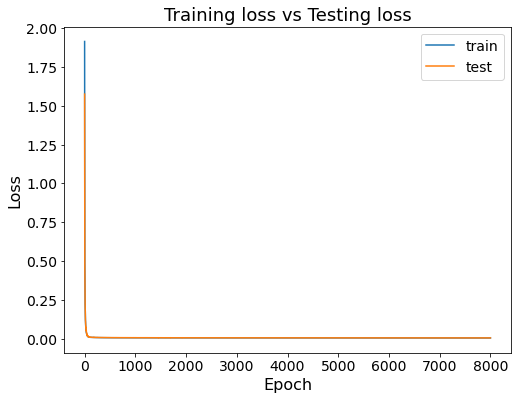

In [110]:
lr = 0.00003
EPOCHS = 8000

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)


model_cnn.compile(
#               optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
              optimizer=Adam(learning_rate=lr_schedule),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=2000)
mc = ModelCheckpoint('saved_model/cnn_shift_best_model_6h_cp1.h5', monitor='val_mae', mode='min', verbose=2, save_best_only=True)


history = model_cnn.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=True,
                       callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [111]:
from tensorflow.keras.models import load_model

saved_model = load_model('saved_model/cnn_shift_best_model_6h_cp1.h5')

In [112]:
yhat = model_cnn.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

error = inv_yhat - inv_y
print(error.shape)

inv_y.shape, inv_yhat.shape (6998, 6) (6998, 6)
(6998, 6)


In [113]:
print('MAE = {}'.format(float("{:.3f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.3f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 2.664
RMSE = 3.709
